## Brain image modeling

### Setup

In [1]:
import shutil
import os
import json
import shutil
import logging
import numpy
import pprint
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from tensor2tensor.utils import trainer_lib
from tensor2tensor import problems
from tensor2tensor.utils import registry
from tensor2tensor.data_generators import allen_brain
from tensor2tensor.data_generators import allen_brain_utils

import tensorflow as tf

from tensorflow.contrib.eager.python import tfe
tfe.enable_eager_execution()
Modes = tf.estimator.ModeKeys

from tk.util import hack_dict_to_cli_args
from tk import experiment
from tk import util

from tensorboard.backend.event_processing import event_file_loader
from protobuf_to_dict import protobuf_to_dict

logging.getLogger().setLevel(logging.INFO)


Instructions for updating:
Use the retry module or similar alternatives.


### Utils

In [2]:

def _load_pdm(ckpt_dir, data_dir="/mnt/nfs-east1-d/data"):
    """Load problem, dataset, and model from ckpt_dir."""

    flags = _get_flags_dict(ckpt_dir)

    hparams_set = flags["hparams_set"]
    problem_name = flags["problem"]
    model_name = flags["model"]

    hp = trainer_lib.create_hparams(
        hparams_set,
        data_dir=data_dir,
        problem_name=problem_name)

    model = registry.model(model_name)(hp, Modes.TRAIN)

    problem_object = problems.problem(problem_name)

    dataset = problem_object.dataset(Modes.TRAIN, data_dir)
    
    return model, dataset, problem_object


def _predict_ith(offset, input_dim=8, output_dim=32):

    with tfe.restore_variables_on_create(ckpt_path):
      for count, example in enumerate(tfe.Iterator(dataset)):
          if count > offset:
            break
      fig=plt.figure(figsize=(8, 8))
      example["inputs"] = tf.reshape(example["inputs"], [1, input_dim, input_dim, 3])
      fig.add_subplot(1, 3, 1)
      plt.imshow(example["inputs"].numpy()[0])
      fig.add_subplot(1, 3, 2)
      example["targets"] = tf.reshape(example["targets"], [1, output_dim, output_dim, 3])
      plt.imshow(example["targets"].numpy()[0])
      example["targets"] = tf.reshape(tf.zeros((1, output_dim, output_dim, 3), dtype=np.uint8), [1, output_dim, output_dim, 3])
      predictions, _ = model(example)
      fig.add_subplot(1,3,3)
      plt.imshow(infer(predictions))
      plt.show()


import numpy as np

def infer(predictions):
    p = predictions.numpy()
    x_max = p.shape[1] # X-position in image
    y_max = p.shape[2] # Y-position in image
    c_max = p.shape[3] # Color channel (r,g,b)

    # The image we will populate
    image = np.zeros((1, x_max, y_max, c_max), dtype=np.uint8)

    batch_idx = 0

    for x in range(0, x_max):
        for y in range(0, y_max):
            for c in range(0, c_max):
                # Get the index of the greatest value in p[0][x][y][c]
                val = np.argmax(p[0][x][y][c])
                image[batch_idx][x][y][c] = np.uint8(np.argmax(p[0][x][y][c]))
    return image[0]


def _latest_ckpt_path(ckpt_dir):
    hits = [hit for hit in tf.gfile.ListDirectory(ckpt_dir) if hit.startswith("model.ckpt")]
    max_hit = 0
    for hit in hits:
        if hit.endswith(".index"):
            hit_numsteps = hit.split(".")[1].split("-")[1]
            if hit_numsteps > max_hit:
                max_hit = hit_numsteps

    if max_hit > 0:
        return os.path.join(ckpt_dir, "model.ckpt-%s" % max_hit)


def _get_flags_dict(ckpt_dir):
    hits = [hit for hit in tf.gfile.ListDirectory(ckpt_dir) if hit.startswith("flags")]
    flags = {}
    for hit in hits:
        with open(os.path.join(ckpt_dir, hit), "r") as f:
            for line in f:
                if line.startswith("--"):
                    pair = line.strip().split("--")[1].split("=")
                    if len(pair) == 2:
                        flags[pair[0]] = pair[1]
                    else:
                        flags[pair[0]] = 'True'

    return flags


In [3]:
ckpt_dir = "/mnt/nfs-east1-d/comparisons/prb-img2img_allen_brain_dim24to32/prb-img2img-allen-brain-dim24to32-j0709-2320-4710/output/master-0/"
print _get_flags_dict(ckpt_dir)["model"]
print _get_flags_dict(ckpt_dir)["hparams_set"]
print _get_flags_dict(ckpt_dir)["problem"]

img2img_transformer
img2img_transformer2d_tiny
img2img_allen_brain_dim24to32


In [22]:
# This isn't a great approach because we can't restore the same model multiple times without an
# error. Sticking with the above for now (involving a kernel restart).

def _predict_ith_v1(offset, ckpt_dir, input_dim=8, output_dim=32):

    model, dataset, problem_obj = _load_pdm(ckpt_dir)
    
    ckpt_path = _latest_ckpt_path(ckpt_dir)
    
    input_dim = problem_obj.input_dim
    output_dim = problem_obj.output_dim
    
    with tfe.restore_variables_on_create(ckpt_path):
      for count, example in enumerate(tfe.Iterator(dataset)):
          if count > offset:
            break
      fig=plt.figure(figsize=(8, 8))
      example["inputs"] = tf.reshape(example["inputs"], [1, input_dim, input_dim, 3])
      fig.add_subplot(1, 3, 1)
      plt.imshow(example["inputs"].numpy()[0])
      fig.add_subplot(1, 3, 2)
      example["targets"] = tf.reshape(example["targets"], [1, output_dim, output_dim, 3])
      plt.imshow(example["targets"].numpy()[0])
      example["targets"] = tf.reshape(tf.zeros((1, output_dim, output_dim, 3), dtype=np.uint8), [1, output_dim, output_dim, 3])
      predictions, _ = model(example)
      fig.add_subplot(1,3,3)
      plt.imshow(infer(predictions))
      plt.show()

### TensorBoard

Start a TensorBoard deployment and service pointing to a log_dir parent to all log_dirs we will write for subsequent experiments, allowing us to compare logs from all experiments via a single TensorBoard instance.

In [ ]:
from tk import kube_tensorboard

tb = kube_tensorboard.TensorBoard(log_dir="/mnt/nfs-east1-d/comparisons",
                                  namespace="kubeflow")

tb.create()

### Training

In [3]:

def _stage(local_app_root, remote_app_root):
    if not os.path.exists(local_app_root):
        raise ValueError("Can't stage from a non-existent source, "
                         "saw %s" % local_app_root)
    shutil.copytree(local_app_root, remote_app_root)


def _configure_experiment(base_name, num_gpu_per_worker=1,
                          problem="img2img_allen_brain_dim8to32",
                          model="img2img_transformer",
                          hparams_set="img2img_transformer2d_tiny",
                          batch_size=4,
                          num_steps=100000,
                          num_workers=0,
                          num_ps=0):

    app_root = "/mnt/nfs-east1-d/work/tk"

    output_dir = os.path.join(app_root, "output")

    job_name = util.generate_job_name(base_name)

    train_args = {
        "problem": problem,
        "model": model,
        "hparams_set": hparams_set,
        "data_dir": "/mnt/nfs-east1-d/data",
        "output_dir": output_dir,
        "train_steps": num_steps,
        "schedule": "train",
        "profile": False,
        "log_device_placement": False,
        "worker_gpu": num_gpu_per_worker,
        "save_checkpoints_secs": 1800,
        "dbgprofile": False, # Saves profiling timelines, viewable in chrome://tracing
        "ssd_mount_path": "/mnt/disks/ssd0",
        "worker_gpu_memory_fraction": 0.95,
        "hparams": "'batch_size=%s'" % batch_size
    }

    args = {
        "job_name": job_name,
        "volume_claim_id": "nfs-east1-d",
        "app_root": app_root,
        "gcp_project": "foo",
        "namespace": "kubeflow",
        "image": "tensorflow/tensorflow:latest-gpu",
        "smoke": True,
        "batch": False,
        "train_args": train_args,
        "cpu": 7,
        "memory": "40Gi",
        "num_gpu": num_gpu_per_worker,
        "num_local_ssd": 1,
        "no_wait": True,
        "num_worker_replicas": num_workers,
        "num_ps_replicas": num_ps,
        "selector_labels": {
          "cloud.google.com/gke-nodepool": "train-gpu-preemptible-%sx-hm" % num_gpu_per_worker,
          "cloud.google.com/gke-accelerator": "nvidia-tesla-k80"
        }
    }

    local_app_root = args["app_root"]

    testing_storage_base = "/mnt/nfs-east1-d/comparisons/%s" % base_name
    remote_app_root = "%s/%s" % (testing_storage_base,
                                 args["job_name"])

    args["train_args"]["output_dir"] = os.path.join(remote_app_root,
                                                    "output")

    with open(os.path.join(local_app_root, "job.sh"), "w") as f:
      f.write("ls /mnt\n")
      f.write("cp -r /mnt/nfs-east1-d/data/* /mnt/ssd0/\n")
      f.write("pip install -e %s/vendor/tensor2tensor\n" % remote_app_root)
      f.write("pip install -e %s\n" % remote_app_root)
      f.write("nvidia-smi\n")
      f.write("python -c 'from tensorflow.python.client import device_lib; print(device_lib.list_local_devices())'\n")
      f.write("echo ${TF_CONFIG}\n")
      f.write("cd %s\n" % remote_app_root)
      cmd = ["python", "-m", "tk.experiment"]
      cmd.extend(hack_dict_to_cli_args(args["train_args"]))
      f.write(" ".join(cmd) + "\n")
      f.write("nvidia-smi\n")
      logging.info(local_app_root)

    _stage(local_app_root, remote_app_root)
    args["app_root"] = remote_app_root
    args["batch"] = True

    return args


In [11]:
comparison_base_name = "example"
args = _configure_experiment(comparison_base_name, batch_size=1)

[2018-07-05 20:40:25,972] /mnt/nfs-east1-d/work/tk


In [12]:
job = experiment.T2TExperiment(**args)
job.run()

[2018-07-05 20:41:29,244] smoke: True


In [18]:
!kubectl logs -n kubeflow example-j0705-2040-9fe3-master-kr9o-0-xw8ww

nfs-east1-d
ssd0
Obtaining file:///mnt/nfs-east1-d/comparisons/example/example-j0705-2040-9fe3/vendor/tensor2tensor
  Running setup.py bdist_wheel for bz2file: started
  Running setup.py bdist_wheel for bz2file: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/81/75/d6/e1317bf09bf1af5a30befc2a007869fa6e1f516b8f7c591cb9
  Running setup.py bdist_wheel for future: started
  Running setup.py bdist_wheel for future: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/bf/c9/a3/c538d90ef17cf7823fa51fc701a7a7a910a80f6a405bf15b1a
  Running setup.py bdist_wheel for gym: started
  Running setup.py bdist_wheel for gym: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/cb/14/71/f4ab006b1e6ff75c2b54985c2f98d0644fffe9c1dddc670925
  Running setup.py bdist_wheel for sympy: started
  Running setup.py bdist_wheel for sympy: finished with status 'done'
  Stored in directory: /root/.cache/pip/wheels/6d/47/7c/40a7cd9b9bd5bad329fcd21d8

### Launch a single-node comparison run

In [4]:

for i in [1, 2, 4]:
  comparison_base_name = "multigpu-4"
  args = _configure_experiment(comparison_base_name, num_gpu_per_worker=i)
  job = experiment.T2TExperiment(**args)
  job.run()


[2018-07-02 19:21:16,814] /mnt/nfs-east1-d/work/tk
[2018-07-02 19:22:25,895] smoke: True
[2018-07-02 19:22:26,024] /mnt/nfs-east1-d/work/tk
[2018-07-02 19:23:32,711] smoke: True
[2018-07-02 19:23:32,839] /mnt/nfs-east1-d/work/tk
[2018-07-02 19:24:41,936] smoke: True
[2018-07-02 19:24:42,072] /mnt/nfs-east1-d/work/tk
[2018-07-02 19:25:48,886] smoke: True


### Visualize comparison results

In [4]:

def _event_dict_list_from_events_file(event_file_path):
    loader = event_file_loader.EventFileLoader(event_file_path)
    events = []
    for event in loader.Load():
      events.append(event)

    output_events = []

    for thing in events:
        d = protobuf_to_dict(thing)

        output_event = {}
        if "wall_time" in d:
            output_event["wall_time"] = d["wall_time"]
        if "step" in d:
            output_event["step"] = d["step"]
        if "summary" in d.keys():
            values = {}
            for value in d["summary"]["value"]:
                if "simple_value" in value.keys():
                    output_event[value["tag"]] = value["simple_value"]

        if "loss" in output_event:
            output_events.append(output_event)
    
    return output_events


def _event_data_for_comparison(comparison_root):
    event_data = []
    tf.logging.info("Identifying event files in experiment subdirectories...")
    paths = tf.gfile.Glob(os.path.join(comparison_root, "*/output/*/events.out*"))
    for i, experiment in enumerate(paths):
        tf.logging.info("Processing experiment events (%s of %s)" % (i + 1, len(paths)))
        event_list = _event_dict_list_from_events_file(experiment)
        event_dict = {"source_path": experiment,
                      "events": event_list}
        # TODO: Also read other experiment metadata
        event_data.append(event_dict)
    tf.logging.info("Finished loading event data for comparison.")
    return event_data


In [5]:

def show_experiment_loss(comparison_base_name):
    
    comparison_root = "/mnt/nfs-east1-d/comparisons/%s" % comparison_base_name
    experiments_data = _event_data_for_comparison(comparison_root)

    plt.figure(num=None, figsize=(15, 6), dpi=80, facecolor='w', edgecolor='k')
    for i, experiment_data in enumerate(experiments_data):
        wall_times = [event["wall_time"] for event in experiment_data["events"]]
        minwt = min(wall_times)
        relative_times = [wt - minwt for wt in wall_times]
        losses = [event["loss"] for event in experiment_data["events"]]
        plt.plot(relative_times, losses, label=str(i))

    plt.legend()
    plt.show()


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-06-30 23:51:38,520] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 4)


[2018-06-30 23:51:51,939] Processing experiment events (1 of 4)


INFO:tensorflow:Processing experiment events (2 of 4)


[2018-06-30 23:51:54,049] Processing experiment events (2 of 4)


INFO:tensorflow:Processing experiment events (3 of 4)


[2018-06-30 23:51:58,758] Processing experiment events (3 of 4)


INFO:tensorflow:Processing experiment events (4 of 4)


[2018-06-30 23:52:03,090] Processing experiment events (4 of 4)


INFO:tensorflow:Finished loading event data for comparison.


[2018-06-30 23:52:08,988] Finished loading event data for comparison.


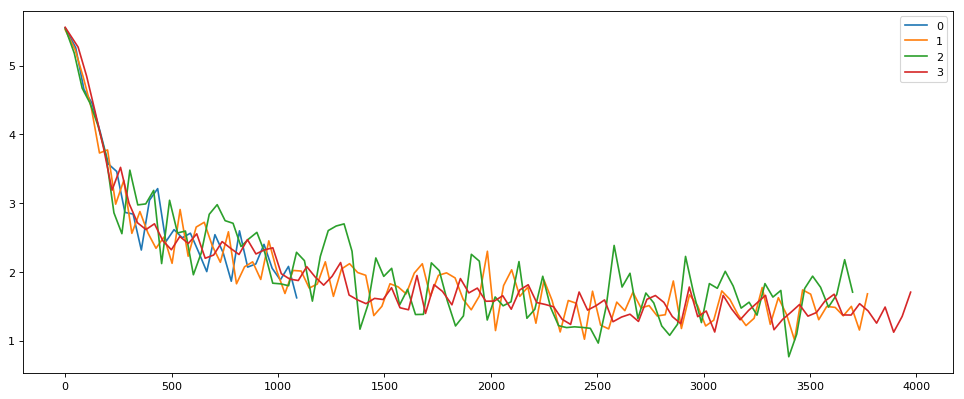

In [19]:

show_experiment_loss("multigpu-2")


In [ ]:

# Blue line was likely preempted

# So looking at this there wasn't a shift in training speed that I expected. Expected the loss
# curve to be more concave with additional GPUs.

# Worth repeating to compare. But do expect optimization to be smoother when processing more
# examples. Also the ability to process more examples is important because it should permit
# dialing back the batch size and increasing the problem size (currently is tiny 8->32px).

# One reason there might not be such a difference between conditions is because the problem
# isn't challenging enough.


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-02 20:40:10,296] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 3)


[2018-07-02 20:40:28,413] Processing experiment events (1 of 3)


INFO:tensorflow:Processing experiment events (2 of 3)


[2018-07-02 20:40:33,437] Processing experiment events (2 of 3)


INFO:tensorflow:Processing experiment events (3 of 3)


[2018-07-02 20:40:39,594] Processing experiment events (3 of 3)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-02 20:40:44,713] Finished loading event data for comparison.


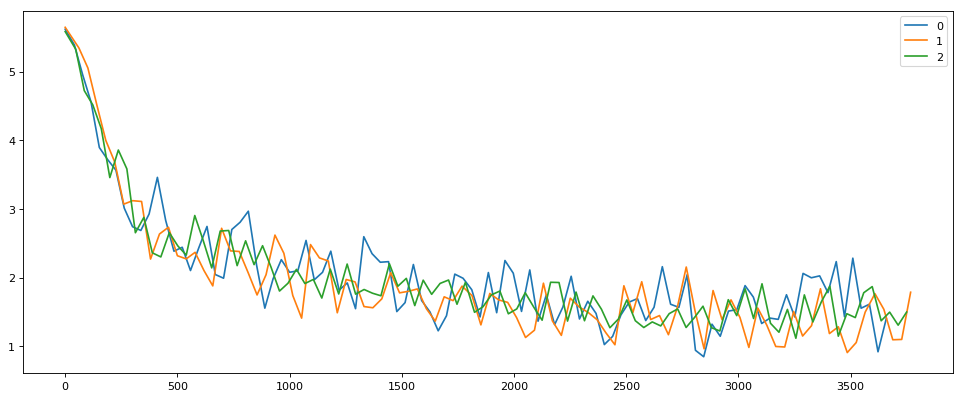

In [13]:

show_experiment_loss("multigpu-4")


In [ ]:

# Again looks to be a smoothing of the 4x condition, as expected.


In [15]:

# Haven't been able to run an 8x job yet - shows added node in cloud dashboard but not via
# kube api


### Larger problem

Checking whether we can run the larger problem at reduced or increased batch sizes without failing with GPU OOM.

In [13]:

for batch_size in [1, 2, 4, 8, 16]:

    args = _configure_experiment("larger-b%s" % batch_size,
                                 problem="img2img_allen_brain_dim48to64",
                                 num_gpu_per_worker=1,
                                 batch_size=batch_size)

    job = experiment.T2TExperiment(**args)
    job.run()


[2018-07-02 23:14:49,768] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:16:03,244] smoke: True
[2018-07-02 23:16:03,392] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:17:14,189] smoke: True
[2018-07-02 23:17:14,319] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:18:25,418] smoke: True
[2018-07-02 23:18:25,542] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:19:37,799] smoke: True
[2018-07-02 23:19:37,921] /mnt/nfs-east1-d/work/tk
[2018-07-02 23:20:52,217] smoke: True


In [ ]:

# All of the above conditions either crashed or were evicted except the batch_size=1 condition,
# presumably because of the intersection of the problem size, batch size, and limited size of K80
# GPU memory.

# Also b_size=[4, 8, and 16] still fail with n_gpu=4


### Inference

In [5]:
hparams_set = "img2img_transformer2d_tiny"
problem_name = "img2img_allen_brain_dim8to32"
model_name = "img2img_transformer"
data_dir = "/mnt/nfs-east1-d/data"

hp = trainer_lib.create_hparams(
    hparams_set,
    data_dir=data_dir,
    problem_name=problem_name)

model = registry.model(model_name)(hp, Modes.TRAIN)

problem_object = problems.problem(problem_name)

dataset = problem_object.dataset(Modes.TRAIN, data_dir)

INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-07-09 19:36:08,292] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim8to32-train*


[2018-07-09 19:36:08,296] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim8to32-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-09 19:36:08,365] partition: 0 num_data_files: 100


In [73]:
for count, example in enumerate(tfe.Iterator(dataset)):
    # Get the 100th example, skipping background
    if count > 100:
        break

In [74]:

# TODO: Examples don't appear to be shuffled propperly! (The first 1725 are background)


In [75]:
example["inputs"] = tf.reshape(example["inputs"], [1, 8, 8, 3])
example["targets"] = tf.reshape(example["targets"], [1, 32, 32, 3])

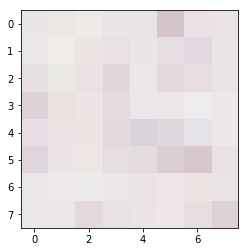

In [76]:
plt.imshow(example["inputs"].numpy()[0])

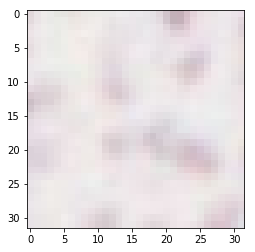

In [77]:
plt.imshow(example["targets"].numpy()[0])

In [78]:
example["inputs"].numpy()[0]

array([[[234, 230, 231],
        [235, 232, 228],
        [238, 234, 232],
        [233, 229, 231],
        [231, 227, 231],
        [213, 196, 204],
        [235, 224, 229],
        [234, 226, 230]],

       [[235, 231, 231],
        [239, 236, 232],
        [236, 229, 228],
        [232, 224, 228],
        [234, 229, 233],
        [230, 222, 227],
        [227, 217, 226],
        [235, 228, 229]],

       [[230, 224, 227],
        [233, 232, 229],
        [234, 226, 226],
        [225, 216, 221],
        [234, 232, 230],
        [229, 218, 219],
        [232, 220, 224],
        [234, 228, 230]],

       [[220, 209, 214],
        [233, 226, 225],
        [237, 229, 229],
        [229, 220, 223],
        [236, 231, 234],
        [235, 231, 233],
        [237, 235, 236],
        [236, 231, 233]],

       [[232, 222, 229],
        [236, 227, 229],
        [236, 228, 227],
        [227, 218, 221],
        [218, 210, 217],
        [221, 216, 222],
        [229, 225, 232],
        [235, 232

In [79]:
example["targets"].numpy()[0]

array([[[225, 216, 219],
        [233, 228, 230],
        [238, 235, 234],
        ...,
        [238, 232, 236],
        [236, 228, 234],
        [236, 224, 233]],

       [[227, 218, 221],
        [234, 228, 230],
        [237, 234, 233],
        ...,
        [236, 231, 235],
        [234, 226, 231],
        [228, 216, 222]],

       [[234, 225, 228],
        [238, 232, 234],
        [239, 237, 235],
        ...,
        [236, 231, 235],
        [233, 225, 230],
        [223, 211, 218]],

       ...,

       [[234, 229, 233],
        [236, 232, 233],
        [237, 233, 232],
        ...,
        [220, 204, 211],
        [217, 204, 212],
        [222, 213, 219]],

       [[232, 227, 231],
        [233, 229, 230],
        [234, 230, 229],
        ...,
        [219, 200, 209],
        [216, 205, 213],
        [224, 219, 225]],

       [[232, 227, 231],
        [233, 229, 230],
        [234, 230, 229],
        ...,
        [217, 199, 209],
        [219, 209, 217],
        [224, 223, 228]]

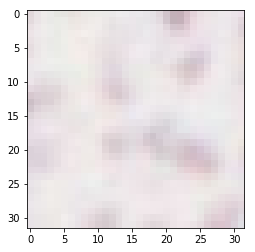

In [80]:
plt.imshow(example["targets"].numpy()[0])

In [81]:
example2 = example
example2["targets"] = tf.reshape(tf.zeros((1, 32, 32, 3), dtype=np.uint8), [1, 32, 32, 3])

In [82]:
ckpt_path = "/mnt/nfs-east1-d/comparisons/multigpu-4/multigpu-4-j0702-1923-8c15/output/master-0/model.ckpt-10000"
with tfe.restore_variables_on_create(ckpt_path):
  predictions, _ = model(example2)

In [16]:
import numpy as np

def infer(predictions):
    p = predictions.numpy()
    x_max = p.shape[1] # X-position in image
    y_max = p.shape[2] # Y-position in image
    c_max = p.shape[3] # Color channel (r,g,b)

    # The image we will populate
    image = np.zeros((1, x_max, y_max, c_max), dtype=np.uint8)

    batch_idx = 0

    for x in range(0, x_max):
        for y in range(0, y_max):
            for c in range(0, c_max):
                # Get the index of the greatest value in p[0][x][y][c]
                val = np.argmax(p[0][x][y][c])
                image[batch_idx][x][y][c] = np.uint8(np.argmax(p[0][x][y][c]))
    return image[0]


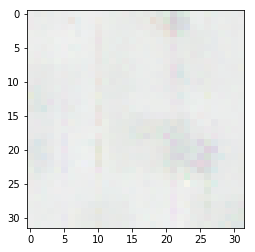

In [86]:
with tfe.restore_variables_on_create(ckpt_path):
  predictions, _ = model(example2)
  plt.imshow(infer(predictions))

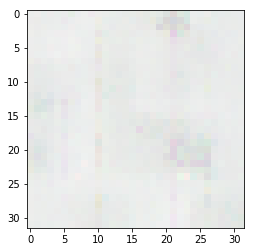

In [87]:
with tfe.restore_variables_on_create(ckpt_path):
  predictions, _ = model(example2)
  plt.imshow(infer(predictions))

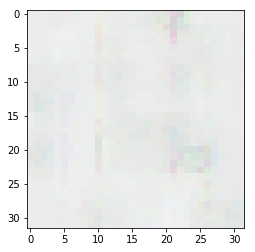

In [88]:
with tfe.restore_variables_on_create(ckpt_path):
  predictions, _ = model(example2)
  plt.imshow(infer(predictions))

In [17]:
def _predict_ith(offset, input_dim=8, output_dim=32):
    with tfe.restore_variables_on_create(ckpt_path):
      for count, example in enumerate(tfe.Iterator(dataset)):
          if count > offset:
            break
      fig=plt.figure(figsize=(8, 8))
      example["inputs"] = tf.reshape(example["inputs"], [1, input_dim, input_dim, 3])
      fig.add_subplot(1, 3, 1)
      plt.imshow(example["inputs"].numpy()[0])
      fig.add_subplot(1, 3, 2)
      example["targets"] = tf.reshape(example["targets"], [1, output_dim, output_dim, 3])
      plt.imshow(example["targets"].numpy()[0])
      example["targets"] = tf.reshape(tf.zeros((1, output_dim, output_dim, 3), dtype=np.uint8), [1, output_dim, output_dim, 3])
      predictions, _ = model(example)
      fig.add_subplot(1,3,3)
      plt.imshow(infer(predictions))
      plt.show()

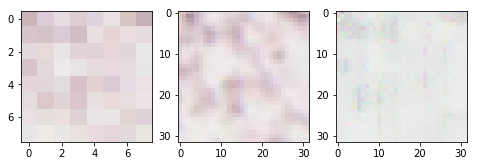

In [116]:
_predict_ith(1724)

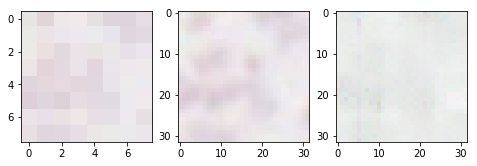

In [111]:
_predict_ith(1726)

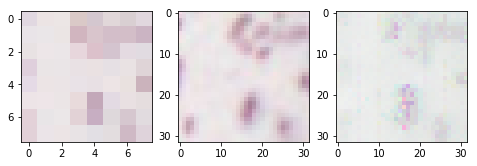

In [112]:
_predict_ith(1727)

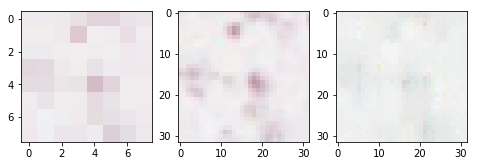

In [113]:
_predict_ith(1728)

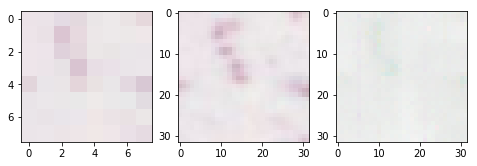

In [117]:
_predict_ith(1729)

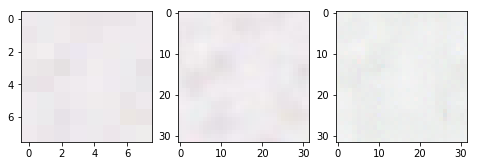

In [119]:
_predict_ith(1730)

In [211]:
# Getting there! 🎉

### Long run

In [121]:
comparison_base_name = "longrun-1"
args = _configure_experiment(comparison_base_name, num_gpu_per_worker=4, num_steps=100000)
job = experiment.T2TExperiment(**args)
job.run()

[2018-07-06 03:12:13,561] /mnt/nfs-east1-d/work/tk
[2018-07-06 03:13:18,151] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-06 17:13:12,970] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 2)


[2018-07-06 17:13:19,645] Processing experiment events (1 of 2)


INFO:tensorflow:Processing experiment events (2 of 2)


[2018-07-06 17:13:56,011] Processing experiment events (2 of 2)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-06 17:14:00,014] Finished loading event data for comparison.


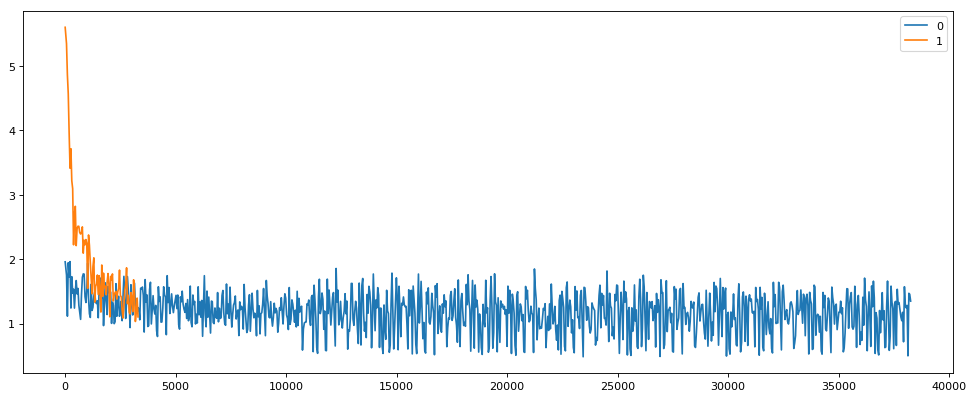

In [124]:

show_experiment_loss("longrun-1")


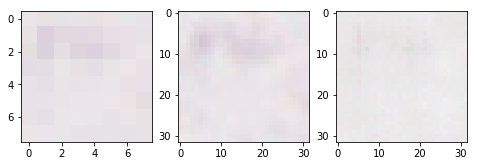

In [9]:

ckpt_path = "/mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/model.ckpt-100000"
_predict_ith(1724)


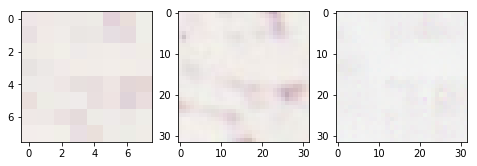

In [17]:

ckpt_path = "/mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/model.ckpt-100000"
_predict_ith(1000)


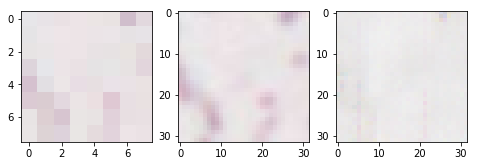

In [18]:

ckpt_path = "/mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/model.ckpt-100000"
_predict_ith(1000)


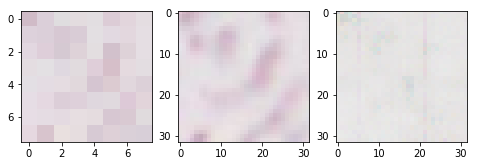

In [22]:

ckpt_path = "/mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/model.ckpt-100000"
_predict_ith(1700)


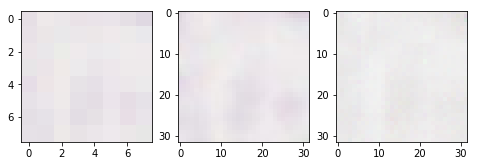

In [10]:

ckpt_path = "/mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/model.ckpt-100000"
_predict_ith(1800)



These inferred images look more pink and more smooth and not entirely unlike blurry microscopy images. Streaks are present here as well. Likely using an adversarial loss will clarify these.

Wondering whether this is the best training dataset given the target images are themselves somewhat blurry.


In [30]:
# What happened at the end of our run?
!tail -n 40 /mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/master-0-logs.txt

loss = 1.2469343, step = 99451 (39.952 sec)
global_step/sec: 2.50104
loss = 1.2852725, step = 99551 (39.984 sec)
global_step/sec: 2.49111
loss = 0.5020779, step = 99651 (40.149 sec)
global_step/sec: 2.48948
loss = 1.4723905, step = 99751 (40.162 sec)
global_step/sec: 2.49531
loss = 1.4562203, step = 99851 (40.075 sec)
global_step/sec: 2.48636
loss = 1.3510604, step = 99951 (40.227 sec)
Saving checkpoints for 100000 into /mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/model.ckpt.
Loss for final step: 1.4526024.
Overriding hparams in img2img_transformer2d_tiny with batch_size=4
From /mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/vendor/tensor2tensor/tensor2tensor/utils/trainer_lib.py:150: __init__ (from tensorflow.contrib.learn.python.learn.estimators.run_config) is deprecated and will be removed in a future version.
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
schedule=train
wo

### Large image up-sampling by padded tiling

#### Load and display raw (target) image

In [13]:
from PIL import Image

# Showing large image
raw_image_path = "/mnt/nfs-east1-d/allen/small/raw/100142550/102173175/raw_102173175.jpg"

img = Image.open(raw_image_path)
img = np.float32(img)
shape = np.shape(img)
shape

/home/jovyan/.conda/envs/py2/lib/python2.7/site-packages/PIL/Image.py:2546: DecompressionBombWarning: Image size (91445760 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning)


(7776, 11760, 3)

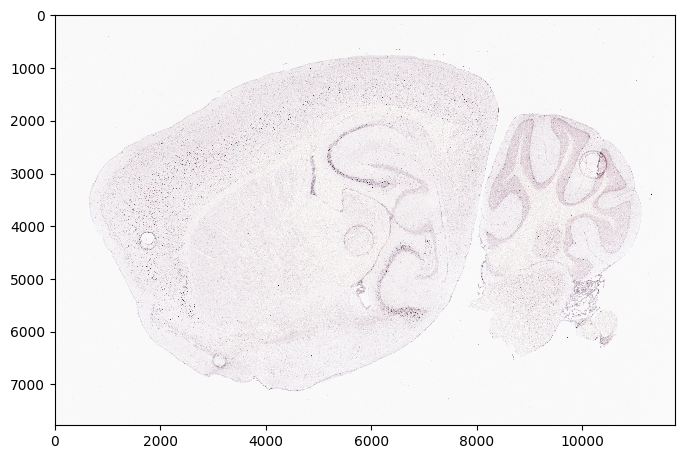

In [21]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(np.uint8(img))

(511, 511, 3)

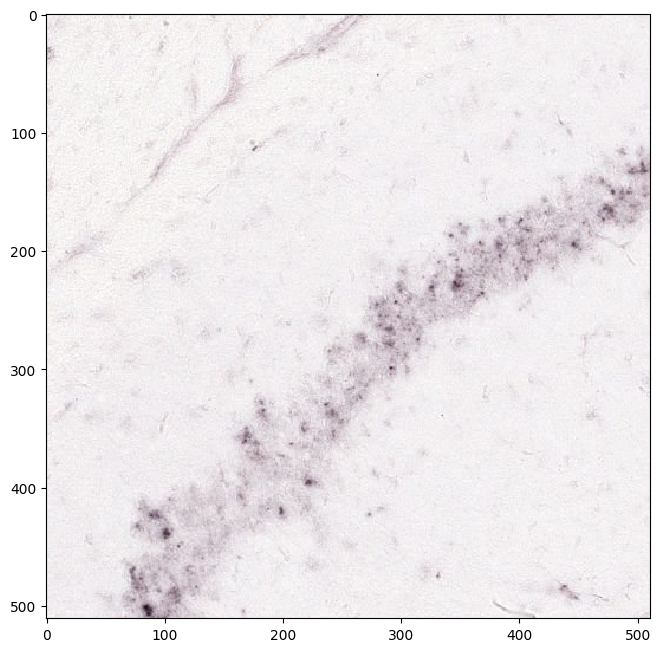

In [6]:
size = 512

h_index = 4
v_index = 10

h_offset = h_index * size
h_end = h_offset + size - 1

v_offset = v_index * size
v_end = v_offset + size - 1

target_image = np.uint8(img[h_offset:h_end, v_offset:v_end])

plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')

plt.imshow(target_image)
np.shape(target_image)

#### Downsample to generate input image

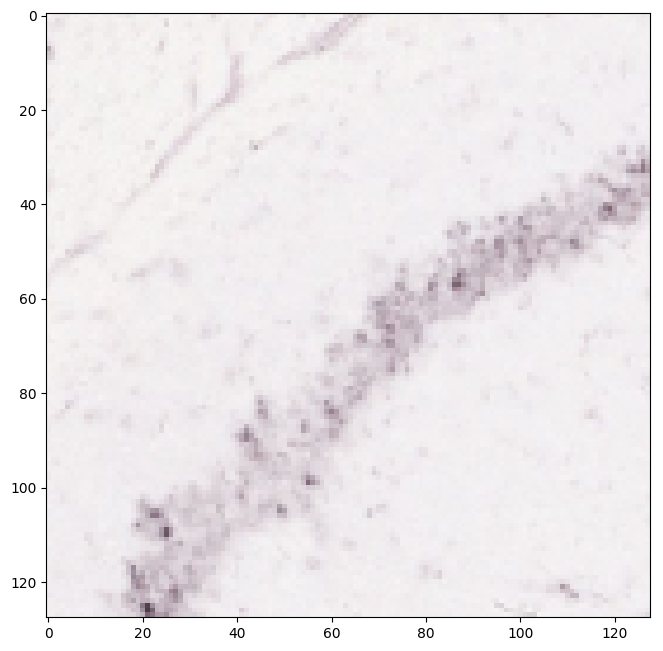

In [7]:
from tensor2tensor.data_generators import image_utils
input_image = image_utils.resize_by_area(target_image, 128).numpy()
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(input_image)

In [11]:

from tensor2tensor.data_generators import image_utils

def get_and_downsample_images(img, size, h_index, v_index, target_dim):

    h_offset = h_index * size
    h_end = h_offset + size - 1

    v_offset = v_index * size
    v_end = v_offset + size - 1

    target_image = np.uint8(img[h_offset:h_end, v_offset:v_end])

    input_image = image_utils.resize_by_area(target_image, target_dim).numpy()
    
    return input_image, target_image


#### Loop over 8x8 patches, inferring 32x32 output (with overlap)

In [12]:
hparams_set = "img2img_transformer2d_tiny"
problem_name = "img2img_allen_brain_dim8to32"
model_name = "img2img_transformer"
data_dir = "/mnt/nfs-east1-d/data"

hp = trainer_lib.create_hparams(
    hparams_set,
    data_dir=data_dir,
    problem_name=problem_name)

model = registry.model(model_name)(hp, Modes.TRAIN)

problem_object = problems.problem(problem_name)

dataset = problem_object.dataset(Modes.TRAIN, data_dir)

INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-07-09 20:52:09,878] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim8to32-train*


[2018-07-09 20:52:09,880] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim8to32-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-09 20:52:09,937] partition: 0 num_data_files: 100


In [13]:
ckpt_path = "/mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/model.ckpt-100000"

In [15]:
import math

# Currently with no overlap
def patchwise_infer(input_image, ckpt_path, target_shape, input_stride=8,
                    target_stride=32, offset=0):

    target_image = np.zeros(target_shape, dtype=np.uint8)

    input_shape = np.shape(input_image)

    upscale_factor = target_stride / input_stride

    with tfe.restore_variables_on_create(ckpt_path):

        x_index_max = input_shape[0] // input_stride
        for x_index in range(0, x_index_max):
            
            #tf.logging.info("\n=============================\n")
            
            tf.logging.info("processing row %s of %s" % (
                x_index, x_index_max))

            x_offset_toggle = 0
            if x_index == 1:
                x_offset_toggle = 1

            for y_index in range(0, input_shape[1] // input_stride):
                
                #tf.logging.info("\n--------------------------------\n")

                example = {}
                
                y_offset_toggle = 0
                if y_index == 1:
                    y_offset_toggle = 1

                input_x_start = x_index * input_stride - offset * x_offset_toggle
                input_x_end = input_x_start + input_stride
                input_y_start = y_index * input_stride - offset * y_offset_toggle
                input_y_end = input_y_start + input_stride

                input_patch = input_image[input_x_start:input_x_end,
                                          input_y_start:input_y_end]

                source_reshape = [1, input_stride, input_stride, 3]
                example["inputs"] = tf.reshape(input_patch, source_reshape)

                upscale_offset = offset * upscale_factor
                target_x_start = int(math.floor(x_index * target_stride - upscale_offset * x_offset_toggle))
                target_y_start = int(math.floor(y_index * target_stride - upscale_offset * y_offset_toggle))
                target_x_end = target_x_start + target_stride
                target_y_end =  target_y_start + target_stride

                zero_target = tf.zeros((1, target_stride, target_stride, 3),
                                       dtype=np.uint8)
                #zero_target = target_image[target_x_start:target_x_end,
                #                           target_y_start:target_y_end]
                target_reshape = [1, target_stride, target_stride, 3]
                example["targets"] = tf.reshape(zero_target, target_reshape)

                predictions, _ = model(example)

                prediction = infer(predictions)

                #tf.logging.info("prediction shape: %s" % str(np.shape(prediction)))

                try:
                  #tf.logging.info("target x start, end: %s, %s" % (target_x_start,
                  #                                                 target_x_end))
                  #tf.logging.info("target y start, end: %s, %s" % (target_y_start,
                  #                                                 target_y_end))

                  target_image[target_x_start:target_x_end,
                               target_y_start:target_y_end] = prediction

                except Exception as e:
                    tf.logging.info("Ran out of space in target, skipping...")

    return target_image

INFO:tensorflow:processing row 0 of 4


[2018-07-09 21:19:40,077] processing row 0 of 4


INFO:tensorflow:processing row 1 of 4


[2018-07-09 21:19:43,303] processing row 1 of 4


INFO:tensorflow:processing row 2 of 4


[2018-07-09 21:19:46,707] processing row 2 of 4


INFO:tensorflow:processing row 3 of 4


[2018-07-09 21:19:52,259] processing row 3 of 4


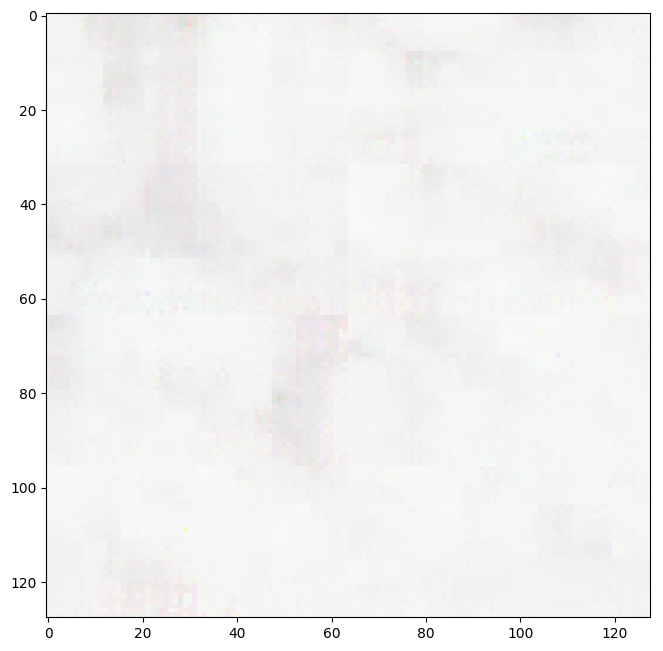

In [65]:
# Small image

input_image, target_image = get_and_downsample_images(img, 128, 32, 40, 32)
inferred = patchwise_infer(input_image, ckpt_path, (128, 128, 3))
fig = plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(inferred)


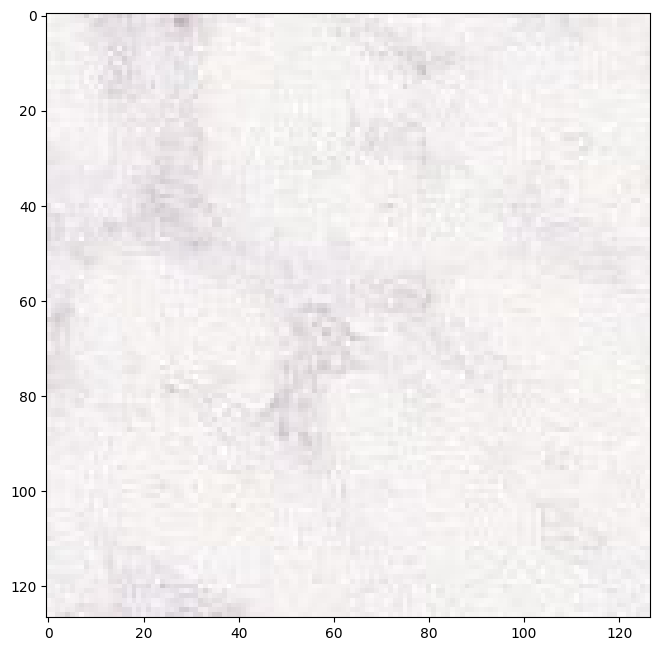

In [67]:
fig = plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(target_image)

INFO:tensorflow:processing row 0 of 16


[2018-07-09 21:20:32,919] processing row 0 of 16


INFO:tensorflow:processing row 1 of 16


[2018-07-09 21:20:46,366] processing row 1 of 16


INFO:tensorflow:processing row 2 of 16


[2018-07-09 21:20:59,973] processing row 2 of 16


INFO:tensorflow:processing row 3 of 16


[2018-07-09 21:21:13,544] processing row 3 of 16


INFO:tensorflow:processing row 4 of 16


[2018-07-09 21:21:27,126] processing row 4 of 16


INFO:tensorflow:processing row 5 of 16


[2018-07-09 21:21:40,691] processing row 5 of 16


INFO:tensorflow:processing row 6 of 16


[2018-07-09 21:21:54,622] processing row 6 of 16


INFO:tensorflow:processing row 7 of 16


[2018-07-09 21:22:08,360] processing row 7 of 16


INFO:tensorflow:processing row 8 of 16


[2018-07-09 21:22:21,959] processing row 8 of 16


INFO:tensorflow:processing row 9 of 16


[2018-07-09 21:22:35,555] processing row 9 of 16


INFO:tensorflow:processing row 10 of 16


[2018-07-09 21:22:49,252] processing row 10 of 16


INFO:tensorflow:processing row 11 of 16


[2018-07-09 21:23:02,980] processing row 11 of 16


INFO:tensorflow:processing row 12 of 16


[2018-07-09 21:23:17,025] processing row 12 of 16


INFO:tensorflow:processing row 13 of 16


[2018-07-09 21:23:30,594] processing row 13 of 16


INFO:tensorflow:processing row 14 of 16


[2018-07-09 21:23:44,218] processing row 14 of 16


INFO:tensorflow:processing row 15 of 16


[2018-07-09 21:23:57,772] processing row 15 of 16


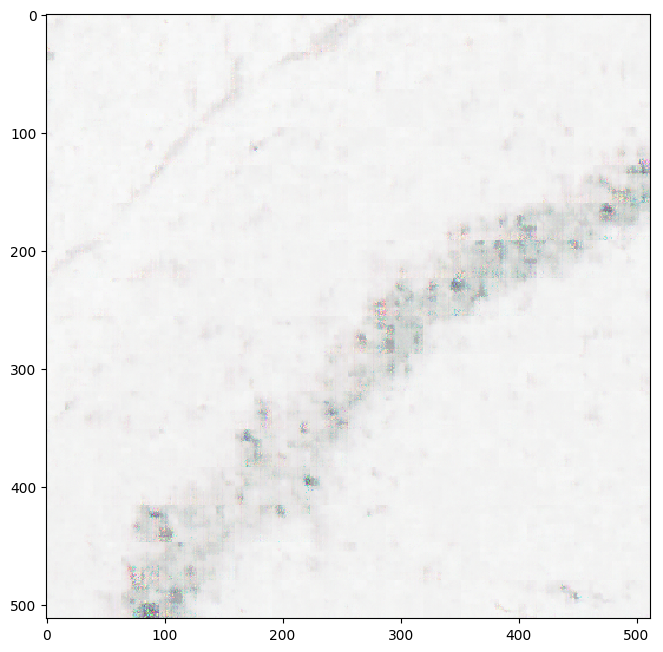

In [68]:
# Large image

input_image, target_image = get_and_downsample_images(img, 512, 4, 10, 128)
inferred = patchwise_infer(input_image, ckpt_path, (512, 512, 3))
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(inferred)


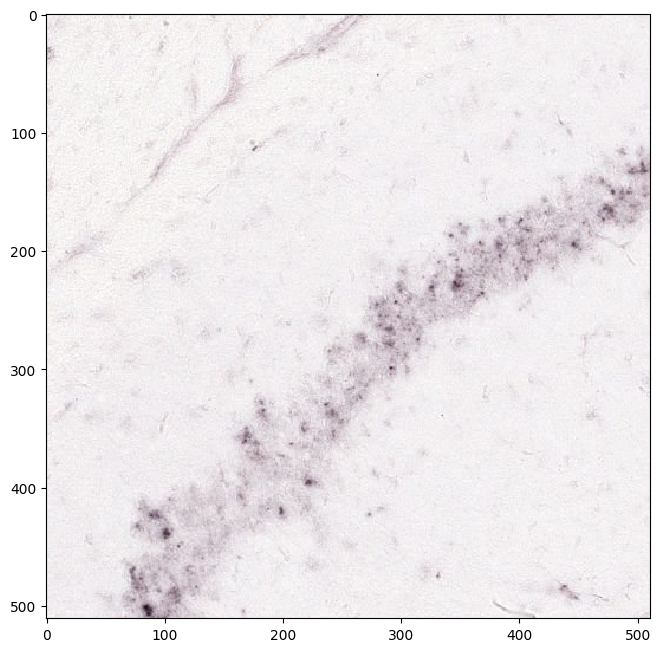

In [69]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(target_image)

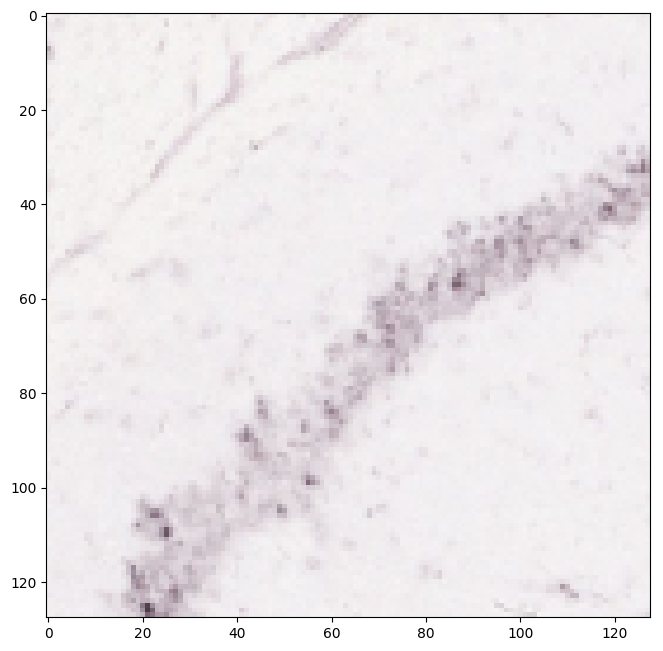

In [71]:
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(input_image)

In [1]:
# Cool! Still seeing edge effects which might mean either need larger problem and overlaps or need
# to make inference autoregressive

### Resource usage during the above long training run?

In [15]:
# This is logged to resources_log.txt in training dir by background process
!tail -n 100 /mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/resources_log.txt

| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:08.0 Off |                    0 |
| N/A   73C    P0   139W / 149W |  11001MiB / 11439MiB |     73%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla K80           Off  | 00000000:00:09.0 Off |                    0 |
| N/A   73C    P0   137W / 149W |  11001MiB / 11439MiB |     89%      Default |
+-------------------------------+----------------------+----------------------+
|   2  Tesla K80           Off  | 00000000:00:0A.0 Off |                    0 |
| N/A   72C    P0   146W / 149W |  11001MiB / 11439MiB |     83%      Default |
+-------------------------------+----------------------+----------------------+
|   3  Tesla K80           Off  | 000000

In [ ]:
import json

def resource_log_to_events(log_path):
    with open(log_path, "r") as f:
        for line in f:
            if line.startswith("{"):
                d = json.loads(line)
                print(d)

log_path = "/mnt/nfs-east1-d/comparisons/longrun-1/longrun-1-j0706-0312-21c0/output/master-0/resources_log.txt"
resource_log_to_events(log_path)

# Resource logger should be revised to write json.loads-able output.

### Long run of larger problem (with smaller upscaling factor)

In [13]:
batch_size = 1

args = _configure_experiment("d48to64-b%s" % batch_size,
                             problem="img2img_allen_brain_dim48to64",
                             num_gpu_per_worker=4,
                             batch_size=batch_size,
                             num_steps=10000)

job = experiment.T2TExperiment(**args)
job.run()


[2018-07-09 17:56:46,448] /mnt/nfs-east1-d/work/tk
[2018-07-09 17:57:53,551] smoke: True


In [ ]:
# The larger problem is about 4x slower than the smaller one (~0.45 step/sec)

INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-17 15:57:34,958] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-07-17 15:57:41,867] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-17 16:16:16,716] Finished loading event data for comparison.


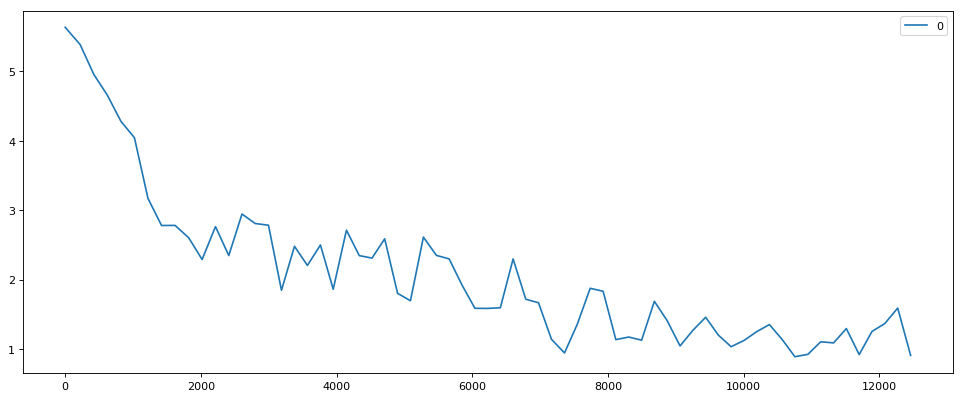

In [18]:
show_experiment_loss("d48to64-b1")

In [7]:
hparams_set = "img2img_transformer2d_tiny"
problem_name = "img2img_allen_brain_dim48to64"
model_name = "img2img_transformer"
data_dir = "/mnt/nfs-east1-d/data"

hp = trainer_lib.create_hparams(
    hparams_set,
    data_dir=data_dir,
    problem_name=problem_name)

model = registry.model(model_name)(hp, Modes.TRAIN)

problem_object = problems.problem(problem_name)

dataset = problem_object.dataset(Modes.TRAIN, data_dir)

INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim48to64-train*


[2018-07-10 15:48:04,377] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim48to64-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-10 15:48:04,450] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-09 19:32:14,304] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-09 19:32:14,307] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-09 19:32:14,309] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-07-09 19:32:22,607] Transforming body output with identity_modality.top


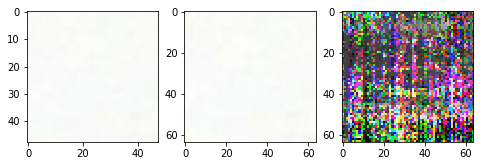

In [12]:
# 0
ckpt_path = "/mnt/nfs-east1-d/comparisons/d48to64-b1/d48to64-b1-j0709-1756-320b/output/master-0/model.ckpt-1"
_predict_ith(100, 48, 64)

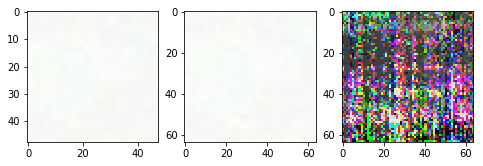

In [13]:
_predict_ith(1600, 48, 64)

INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-09 20:07:12,887] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-09 20:07:12,890] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-09 20:07:12,893] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-07-09 20:07:21,005] Transforming body output with identity_modality.top


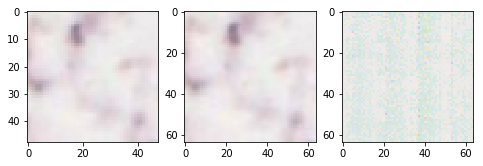

In [9]:
# 1830
ckpt_path = "/mnt/nfs-east1-d/comparisons/d48to64-b1/d48to64-b1-j0709-1756-320b/output/master-0/model.ckpt-1830"
_predict_ith(1700, 48, 64)

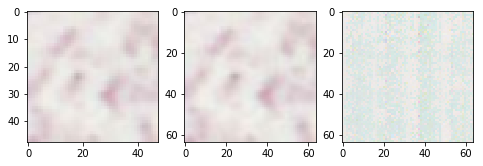

In [10]:
_predict_ith(1700, 48, 64)

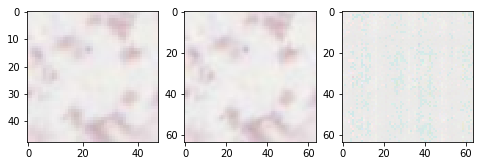

In [12]:
# 2787
ckpt_path = "/mnt/nfs-east1-d/comparisons/d48to64-b1/d48to64-b1-j0709-1756-320b/output/master-0/model.ckpt-2787"
_predict_ith(1800, 48, 64)

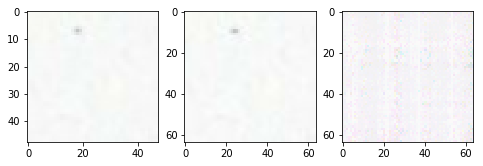

In [9]:
_predict_ith(1700, 48, 64)

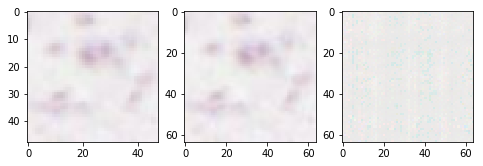

In [10]:
_predict_ith(1800, 48, 64)

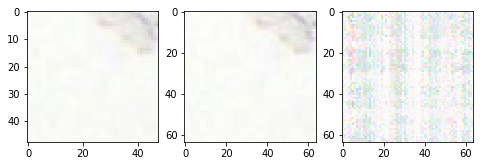

In [11]:
# 3733
ckpt_path = "/mnt/nfs-east1-d/comparisons/d48to64-b1/d48to64-b1-j0709-1756-320b/output/master-0/model.ckpt-3733"
_predict_ith(1900, 48, 64)

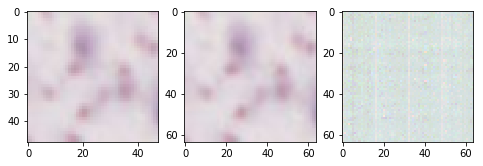

In [8]:
_predict_ith(1700, 48, 64)

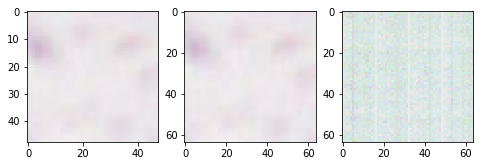

In [9]:
_predict_ith(1700, 48, 64)

INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-09 20:15:41,142] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-09 20:15:41,145] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-09 20:15:41,148] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-07-09 20:15:49,376] Transforming body output with identity_modality.top


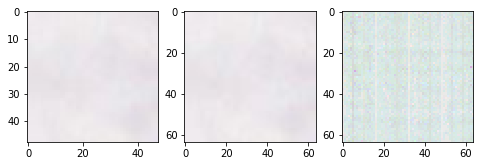

In [4]:
# 3733
ckpt_path = "/mnt/nfs-east1-d/comparisons/d48to64-b1/d48to64-b1-j0709-1756-320b/output/master-0/model.ckpt-3733"
_predict_ith(1900, 48, 64)

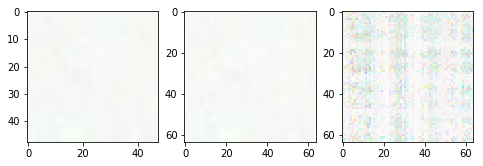

In [5]:
_predict_ith(1900, 48, 64)

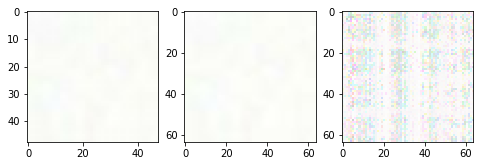

In [6]:
_predict_ith(1900, 48, 64)

INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-09 20:38:41,386] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-09 20:38:41,388] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-09 20:38:41,391] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-07-09 20:38:49,802] Transforming body output with identity_modality.top


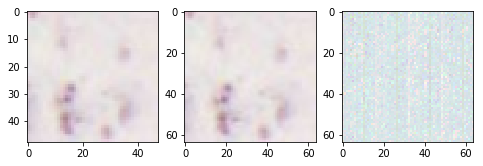

In [5]:
# 4693
ckpt_path = "/mnt/nfs-east1-d/comparisons/d48to64-b1/d48to64-b1-j0709-1756-320b/output/master-0/model.ckpt-4693"
_predict_ith(1900, 48, 64)

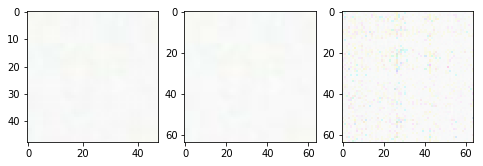

In [9]:
_predict_ith(2100, 48, 64)

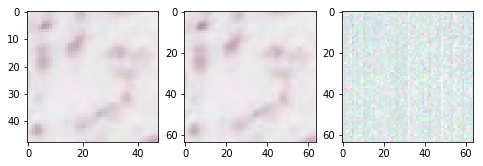

In [8]:
_predict_ith(2000, 48, 64)

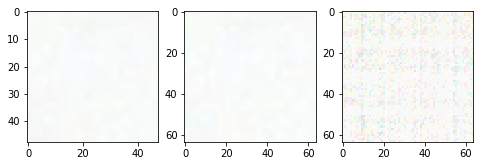

In [7]:
# 6600
ckpt_path = "/mnt/nfs-east1-d/comparisons/d48to64-b1/d48to64-b1-j0709-1756-320b/output/master-0/model.ckpt-6600"
_predict_ith(1800, 48, 64)

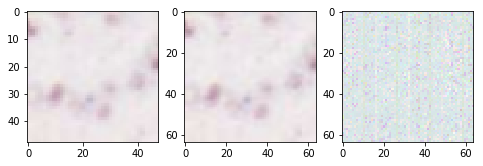

In [8]:
_predict_ith(1600, 48, 64)

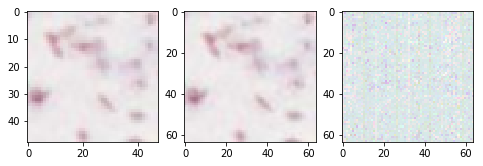

In [9]:
_predict_ith(1200, 48, 64)

In [ ]:
# So apparently it's not loading a new version of the model if a previous one has been loaded
# Should have the model object instantiated within predict_ith instead of shared (across restore
# operations).

In [ ]:
# A key problem here is that with the current hardware and model params can only run with a
# batch size of 4.

In [ ]:
# This run crashed at about step 6600 with OOM.

#### Infer large image using model trained on larger problem

INFO:tensorflow:processing row 0 of 16


[2018-07-09 21:42:40,479] processing row 0 of 16


INFO:tensorflow:processing row 1 of 16


[2018-07-09 21:42:53,403] processing row 1 of 16


INFO:tensorflow:processing row 2 of 16


[2018-07-09 21:43:06,417] processing row 2 of 16


INFO:tensorflow:processing row 3 of 16


[2018-07-09 21:43:19,354] processing row 3 of 16


INFO:tensorflow:processing row 4 of 16


[2018-07-09 21:43:32,376] processing row 4 of 16


INFO:tensorflow:processing row 5 of 16


[2018-07-09 21:43:45,346] processing row 5 of 16


INFO:tensorflow:processing row 6 of 16


[2018-07-09 21:43:58,538] processing row 6 of 16


INFO:tensorflow:processing row 7 of 16


[2018-07-09 21:44:15,756] processing row 7 of 16


INFO:tensorflow:processing row 8 of 16


[2018-07-09 21:44:28,747] processing row 8 of 16


INFO:tensorflow:processing row 9 of 16


[2018-07-09 21:44:41,838] processing row 9 of 16


INFO:tensorflow:processing row 10 of 16


[2018-07-09 21:44:54,862] processing row 10 of 16


INFO:tensorflow:processing row 11 of 16


[2018-07-09 21:45:07,854] processing row 11 of 16


INFO:tensorflow:processing row 12 of 16


[2018-07-09 21:45:20,820] processing row 12 of 16


INFO:tensorflow:processing row 13 of 16


[2018-07-09 21:45:33,745] processing row 13 of 16


INFO:tensorflow:processing row 14 of 16


[2018-07-09 21:45:46,661] processing row 14 of 16


INFO:tensorflow:processing row 15 of 16


[2018-07-09 21:45:59,637] processing row 15 of 16


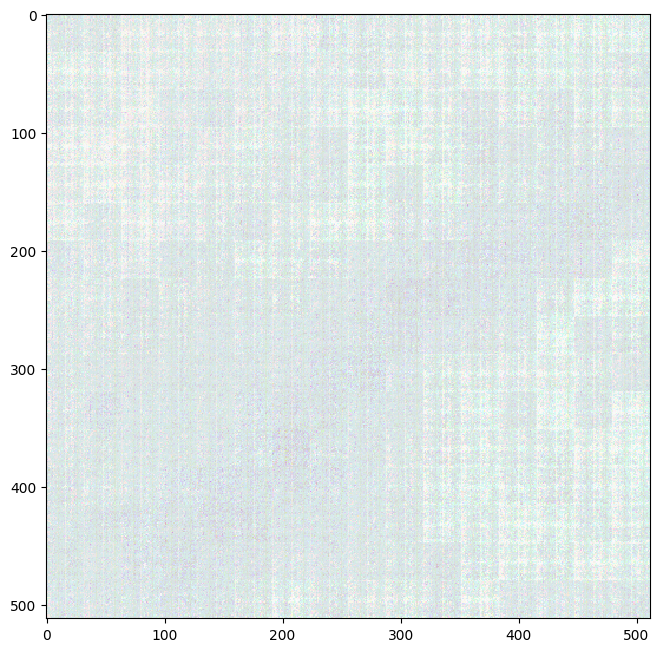

In [16]:

input_image, target_image = get_and_downsample_images(img, 512, 4, 10, 128)
inferred = patchwise_infer(input_image, ckpt_path, (512, 512, 3))
plt.figure(num=None, figsize=(8, 8), dpi=100, facecolor='w', edgecolor='k')
plt.imshow(inferred)


In [ ]:
# That makes the model trained on the smaller version of the problem look really good!!

### Experiment with various smaller problems

In [26]:

probs = ["img2img_allen_brain_dim8to16",
         "img2img_allen_brain_dim16to32",
         "img2img_allen_brain_dim24to32"]

batch_size = 4

for prob in probs:

    args = _configure_experiment("prb-%s" % prob,
                                 problem=prob,
                                 num_gpu_per_worker=4,
                                 batch_size=batch_size,
                                 num_steps=20000)

    job = experiment.T2TExperiment(**args)

    job.run()


[2018-07-09 23:18:28,212] /mnt/nfs-east1-d/work/tk
[2018-07-09 23:19:32,655] smoke: True
[2018-07-09 23:19:32,775] /mnt/nfs-east1-d/work/tk
[2018-07-09 23:20:40,000] smoke: True
[2018-07-09 23:20:40,122] /mnt/nfs-east1-d/work/tk
[2018-07-09 23:21:45,843] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-10 15:32:36,198] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 3)


[2018-07-10 15:33:08,351] Processing experiment events (1 of 3)


INFO:tensorflow:Processing experiment events (2 of 3)


[2018-07-10 15:35:31,389] Processing experiment events (2 of 3)


INFO:tensorflow:Processing experiment events (3 of 3)


[2018-07-10 15:36:06,706] Processing experiment events (3 of 3)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-10 15:36:10,320] Finished loading event data for comparison.


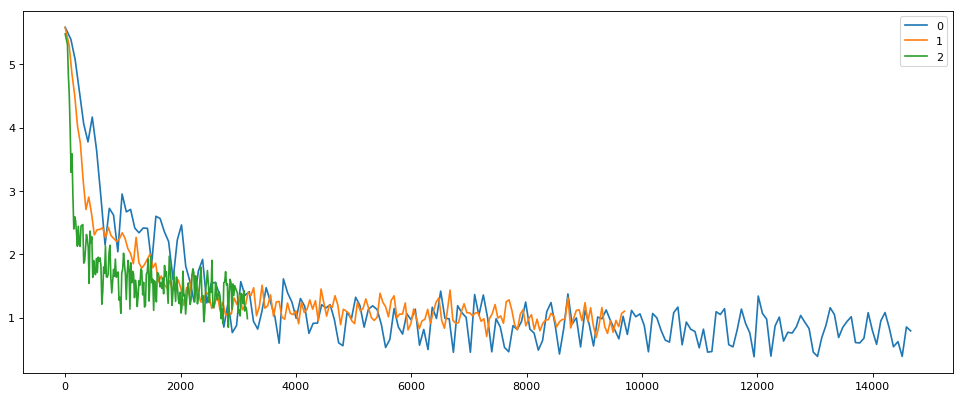

In [33]:
show_experiment_loss("prb*")

In [23]:
# Would be good to be able to specify one or multiple flags keys to specify what to display
# in the figure legend

INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-07-10 16:51:12,862] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim8to16-train*


[2018-07-10 16:51:12,865] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim8to16-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-10 16:51:13,031] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-10 16:51:14,079] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-10 16:51:14,083] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-10 16:51:14,087] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-07-10 16:51:14,607] Transforming body output with identity_modality.top


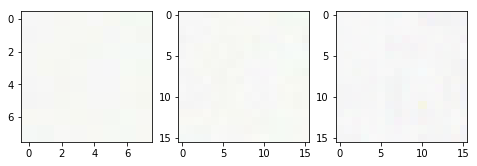

In [5]:

ckpt_dir = "/mnt/nfs-east1-d/comparisons/prb-img2img_allen_brain_dim8to16/prb-img2img-allen-brain-dim8to16-j0709-2318-2b37/output/master-0/"
ckpt_path = _latest_ckpt_path(ckpt_dir)
model, dataset, problem_obj = _load_pdm(ckpt_dir)
_predict_ith(2100, 8, 16)


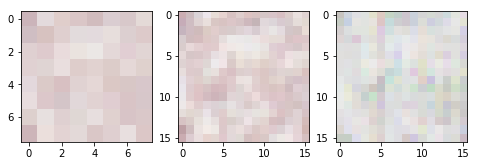

In [6]:
_predict_ith(2100, 8, 16)

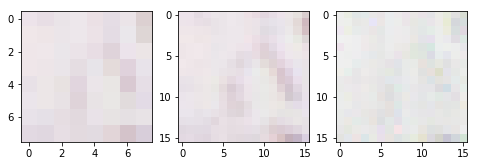

In [7]:
_predict_ith(1700, 8, 16)

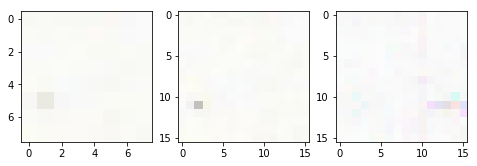

In [6]:
_predict_ith(2100, 8, 16)

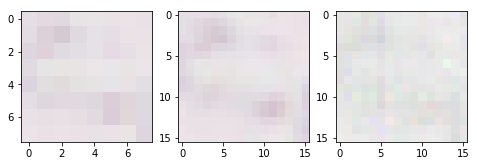

In [9]:
_predict_ith(2100, 8, 16)

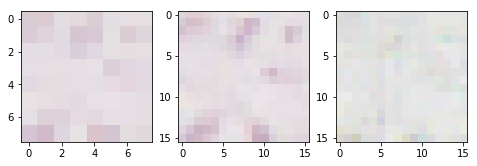

In [8]:
_predict_ith(2100, 8, 16)

INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-07-10 16:33:21,064] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim16to32-train*


[2018-07-10 16:33:21,066] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim16to32-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-10 16:33:21,152] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-10 16:33:22,175] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-10 16:33:22,178] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-10 16:33:22,181] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-07-10 16:33:23,278] Transforming body output with identity_modality.top


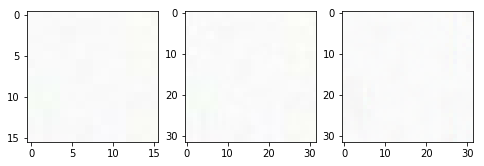

In [4]:
ckpt_dir = "/mnt/nfs-east1-d/comparisons/prb-img2img_allen_brain_dim16to32/prb-img2img-allen-brain-dim16to32-j0709-2319-7a66/output/master-0"
ckpt_path = _latest_ckpt_path(ckpt_dir)
model, dataset, problem_obj = _load_pdm(ckpt_dir)
_predict_ith(2100, 16, 32)

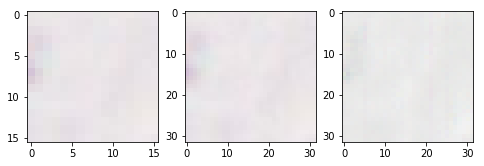

In [5]:
_predict_ith(2100, 16, 32)

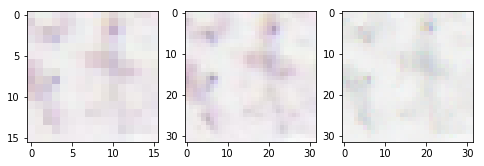

In [8]:
_predict_ith(2100, 16, 32)

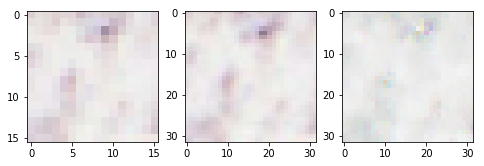

In [10]:
_predict_ith(2100, 16, 32)

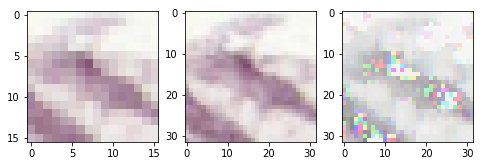

In [14]:
_predict_ith(2100, 16, 32)

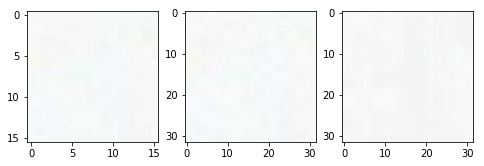

In [15]:
_predict_ith(2100, 16, 32)

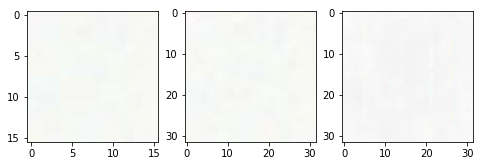

In [16]:
_predict_ith(2100, 16, 32)

In [ ]:
# I think this could get a lot better if trained longer and with a larger batch size.

INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-07-10 16:38:36,273] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim24to32-train*


[2018-07-10 16:38:36,277] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain_dim24to32-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-10 16:38:36,356] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-10 16:38:37,271] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-10 16:38:37,274] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-10 16:38:37,277] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-07-10 16:38:38,592] Transforming body output with identity_modality.top


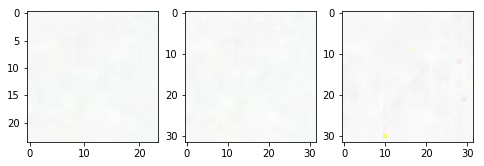

In [3]:
ckpt_dir = "/mnt/nfs-east1-d/comparisons/prb-img2img_allen_brain_dim24to32/prb-img2img-allen-brain-dim24to32-j0709-2320-4710/output/master-0"
ckpt_path = _latest_ckpt_path(ckpt_dir)
model, dataset, problem_obj = _load_pdm(ckpt_dir)
_predict_ith(2100, 24, 32)

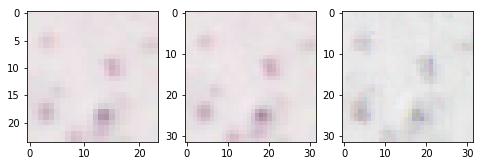

In [4]:
_predict_ith(2100, 24, 32)

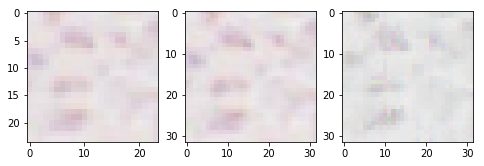

In [5]:
_predict_ith(2100, 24, 32)

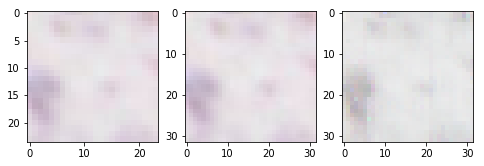

In [15]:
_predict_ith(2100, 24, 32)

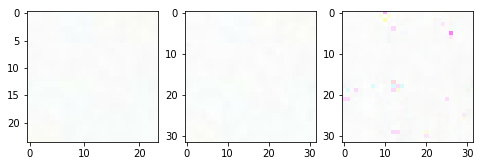

In [10]:
_predict_ith(2100, 24, 32)

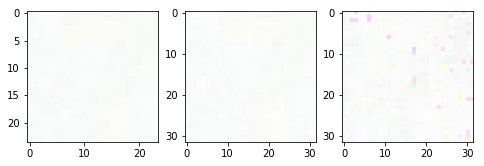

In [11]:
_predict_ith(2100, 24, 32)

#### Search for max batch size that works with dim16to32

In [11]:

problem_name = "img2img_allen_brain_dim16to32"

batch_sizes = [14, 15, 16]

for bsize in batch_sizes:

    args = _configure_experiment("b%s-16to32" % bsize,
                                 problem=problem_name,
                                 num_gpu_per_worker=4,
                                 batch_size=bsize,
                                 num_steps=10)

    job = experiment.T2TExperiment(**args)

    job.run()


[2018-07-10 17:04:25,058] /mnt/nfs-east1-d/work/tk
[2018-07-10 17:05:27,134] smoke: True
[2018-07-10 17:05:27,255] /mnt/nfs-east1-d/work/tk
[2018-07-10 17:06:36,895] smoke: True
[2018-07-10 17:06:37,014] /mnt/nfs-east1-d/work/tk
[2018-07-10 17:07:42,055] smoke: True


In [ ]:
# all of 5, 9, 13 were able to save checkpoints meaning an OOM was not created in startup
# but could occur along the way.
# 17 crashed after "...failed to query event: CUDA_ERROR_ECC_UNCORRECTABLE"

#### Long run with 16to32 with larger batch size

In [12]:
bsize = 13

problem_name = "img2img_allen_brain_dim16to32"

args = _configure_experiment("vlr-b%s-16to32" % bsize,
                             problem=problem_name,
                             num_gpu_per_worker=4,
                             batch_size=bsize,
                             num_steps=30000)

job = experiment.T2TExperiment(**args)

job.run()

[2018-07-10 17:11:31,771] /mnt/nfs-east1-d/work/tk
[2018-07-10 17:12:33,764] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-11 19:58:53,055] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-07-11 19:58:58,345] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-11 20:00:13,911] Finished loading event data for comparison.


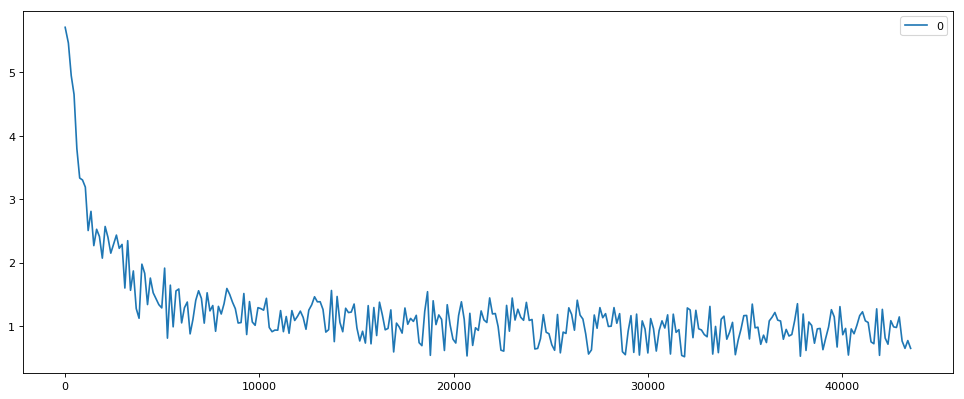

In [17]:
show_experiment_loss("vlr-b13*")

### Distributed?

Would like to be able to push the batch size larger.

In [24]:
bsize = 1

problem_name = "img2img_allen_brain_dim16to32"

args = _configure_experiment("maybe-distributed",
                             problem=problem_name,
                             num_gpu_per_worker=1,
                             batch_size=bsize,
                             num_steps=10,
                             num_workers=1,
                             num_ps=1)

job = experiment.T2TExperiment(**args)

job.run()


[2018-07-11 21:08:50,331] /mnt/nfs-east1-d/work/tk
[2018-07-11 21:09:58,338] smoke: True


In [25]:
!kubectl logs -n kubeflow maybe-distributed-j0711-2108-7528-master-tzfj-0-wcq3r | tail -n 20

2018-07-11 21:17:53.800014: E tensorflow/core/distributed_runtime/master.cc:272] CreateSession failed because worker /job:ps/replica:0/task:0 returned error: Unavailable: OS Error
2018-07-11 21:17:53.800128: E tensorflow/core/distributed_runtime/master.cc:272] CreateSession failed because worker /job:ps/replica:0/task:0 returned error: Unavailable: OS Error
INFO:tensorflow:An error was raised while a session was being created. This may be due to a preemption of a connected worker or parameter server. A new session will be created. Error: OS Error
INFO:tensorflow:Graph was finalized.
2018-07-11 21:17:55.064218: E tensorflow/core/distributed_runtime/master.cc:272] CreateSession failed because worker /job:ps/replica:0/task:0 returned error: Unavailable: OS Error
2018-07-11 21:17:55.064323: E tensorflow/core/distributed_runtime/master.cc:272] CreateSession failed because worker /job:ps/replica:0/task:0 returned error: Unavailable: OS Error
INFO:tensorflow:An error was raised while a sessio

In [27]:
bsize = 1

problem_name = "img2img_allen_brain_dim16to32"

args = _configure_experiment("maybe-distributed",
                             problem=problem_name,
                             num_gpu_per_worker=1,
                             batch_size=bsize,
                             num_steps=1000,
                             num_workers=1,
                             num_ps=0)

job = experiment.T2TExperiment(**args)

job.run()

[2018-07-11 21:25:59,240] /mnt/nfs-east1-d/work/tk
[2018-07-11 21:27:12,479] smoke: True


In [ ]:
# Here the master just proceeded without the worker (which hung waiting for variables
# to be initialized). Suggesting the master did not know about the worker.

# The master is getting phoned by the worker but the master isn't responding probably
# because the master thinks everything is duely initialized.

# This appears to work fine when all of these are running on the same host.

### Problem variants share TFRecords?

In [28]:
# Configured each problem variant with dataset_filename method to avoid need
# to run datagen separately for each problem (that all share same base examples).

bsize = 1

problem_name = "img2img_allen_brain_dim8to32"

args = _configure_experiment("sharestfrecords",
                             problem=problem_name,
                             num_gpu_per_worker=1,
                             batch_size=bsize,
                             num_steps=10)

job = experiment.T2TExperiment(**args)

job.run()

[2018-07-12 22:00:12,539] /mnt/nfs-east1-d/work/tk
[2018-07-12 22:01:12,544] smoke: True


In [ ]:
# Yes.

### In-painting run

In [31]:
# Does the in-painting problem train?

bsize = 1

problem_name = "img2img_allen_brain_dim16to16_paint1"

args = _configure_experiment("inpaints2",
                             problem=problem_name,
                             num_gpu_per_worker=4,
                             batch_size=bsize,
                             num_steps=100)

job = experiment.T2TExperiment(**args)

job.run()

[2018-07-12 22:14:55,226] /mnt/nfs-east1-d/work/tk
[2018-07-12 22:16:07,771] smoke: True


In [ ]:
# Yes, but still seeing NaN loss and crash because of GPU OOM.

In [17]:
bsize = 1

problem_name = "img2img_allen_brain_dim16to16_paint1"

args = _configure_experiment("inpaints3",
                             problem=problem_name,
                             num_gpu_per_worker=4,
                             batch_size=bsize,
                             num_steps=100)

job = experiment.T2TExperiment(**args)

job.run()

[2018-07-16 18:48:10,185] /mnt/nfs-east1-d/work/tk
[2018-07-16 18:49:38,593] smoke: True


### Verify previously working run

In [34]:
# Now that target images are being produced by random cropping instead of downsampling
# interested in seeing whether previous result holds or perhaps improves. Also applied
# threshold that excluded some background images.

bsize = 4

problem_name = "img2img_allen_brain_dim8to32"

args = _configure_experiment("lr-b%s-8to32" % bsize,
                             problem=problem_name,
                             num_gpu_per_worker=4,
                             batch_size=bsize,
                             num_steps=30000)

job = experiment.T2TExperiment(**args)

job.run()

[2018-07-13 00:05:33,687] /mnt/nfs-east1-d/work/tk
[2018-07-13 00:06:36,593] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-16 17:39:13,053] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 2)


[2018-07-16 17:39:40,848] Processing experiment events (1 of 2)


INFO:tensorflow:Processing experiment events (2 of 2)


[2018-07-16 17:39:43,758] Processing experiment events (2 of 2)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-16 17:39:46,948] Finished loading event data for comparison.


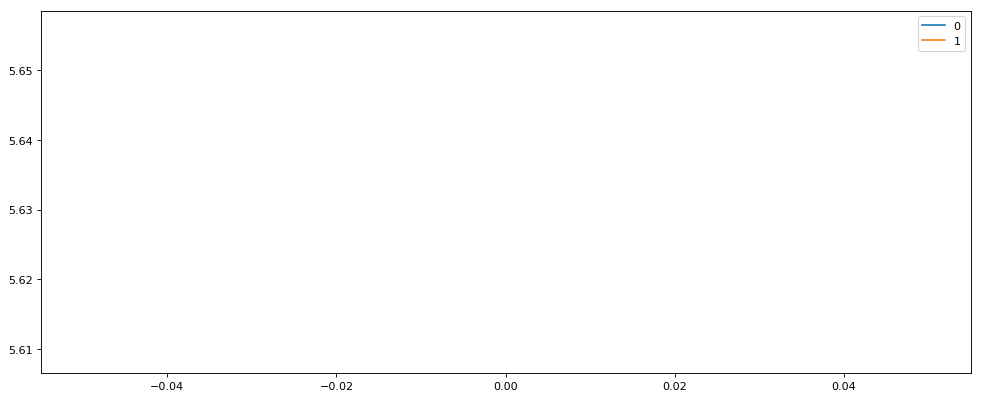

In [10]:
show_experiment_loss("lr-b4-8to32")

In [15]:

# So currently not sure why these runs are failing with NaN / OOM but could have to do with
# changes made while working on the distributed stuff. But that's one of the key next things
# to investigate.

# I think this may have had to do with changed made to the TF_CONFIG parser in experiment.py
# Here's a new run with all of that commented out

bsize = 4

problem_name = "img2img_allen_brain_dim8to32"

args = _configure_experiment("oom-rollback-2",
                             problem=problem_name,
                             num_gpu_per_worker=1,
                             batch_size=bsize,
                             num_steps=100)

job = experiment.T2TExperiment(**args)

job.run()


[2018-07-16 18:40:48,164] /mnt/nfs-east1-d/work/tk
[2018-07-16 18:42:17,434] smoke: True


In [ ]:

# Yes that fixed it but changed at the same time per_process_gpu_memory_fraction 😜
# re-trying without that change.

# Yes still works / no OOM error/crash


In [18]:
# Now verifying previously working run

bsize = 4

problem_name = "img2img_allen_brain_dim8to32"

args = _configure_experiment("lr-b%s-8to32-2" % bsize,
                             problem=problem_name,
                             num_gpu_per_worker=4,
                             batch_size=bsize,
                             num_steps=30000)

job = experiment.T2TExperiment(**args)

job.run()

[2018-07-16 18:49:38,738] /mnt/nfs-east1-d/work/tk
[2018-07-16 18:51:03,984] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-16 21:12:16,365] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-07-16 21:12:26,708] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-16 21:12:37,715] Finished loading event data for comparison.


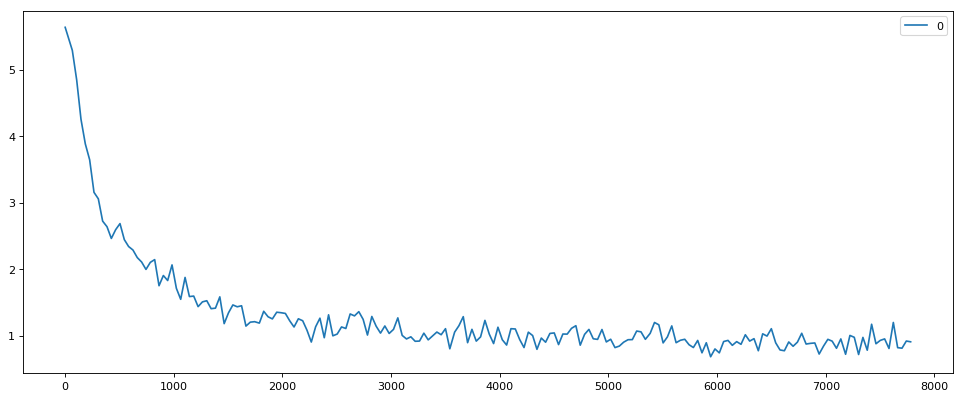

In [12]:

show_experiment_loss("lr-b4-8to32-2")


In [ ]:

# This loss curve looks more stable which might be because the target images are more crisp (and thus the problem
# has a more specific answer).


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-07-16 20:42:01,330] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


[2018-07-16 20:42:01,335] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-16 20:42:01,428] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-16 20:42:02,674] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-16 20:42:02,677] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-16 20:42:02,682] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-07-16 20:42:04,002] Transforming body output with identity_modality.top


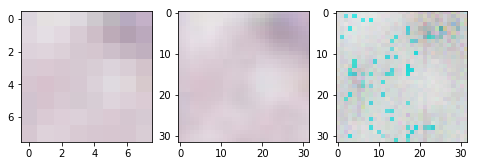

In [7]:

ckpt_dir = "/mnt/nfs-east1-d/comparisons/lr-b4-8to32-2/lr-b4-8to32-2-j0716-1849-b2c1/output/master-0"
ckpt_path = _latest_ckpt_path(ckpt_dir)
model, dataset, problem_obj = _load_pdm(ckpt_dir)
_predict_ith(1200, 8, 32)


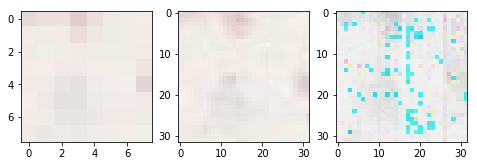

In [18]:
_predict_ith(1200, 8, 32)

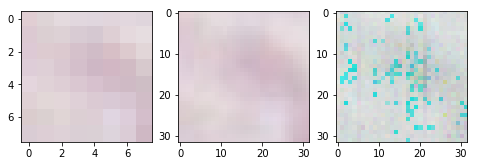

In [9]:
_predict_ith(1500, 8, 32)

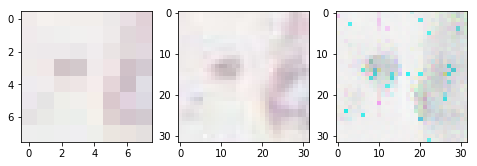

In [13]:
_predict_ith(1500, 8, 32)

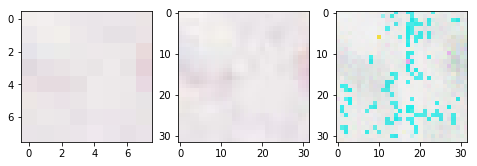

In [11]:
_predict_ith(1500, 8, 32)

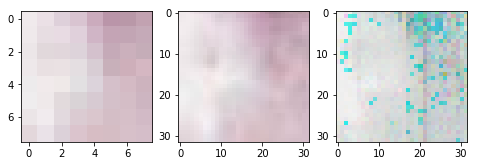

In [16]:
_predict_ith(1500, 8, 32)

In [ ]:

# So the examples still look fine and to some extent it looks to be inferring good outputs but overlayed with these 
# brightly colored pixels. I'd be curious whether this continues as the model trains for another 20k iterations.

# Not quite clear what changed though - the problem def was updated to
# * Threshold to only include images with intensities above 230
# * Random crop instead of down-sample targets
# * Change in the tf.clip / *255 stuff.


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-07-16 21:13:48,415] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


[2018-07-16 21:13:48,419] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-16 21:13:48,506] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-16 21:13:49,827] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-16 21:13:49,830] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-16 21:13:49,834] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-07-16 21:13:51,169] Transforming body output with identity_modality.top


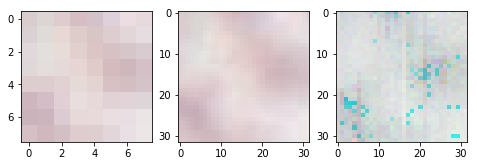

In [7]:

# With additional training

ckpt_dir = "/mnt/nfs-east1-d/comparisons/lr-b4-8to32-2/lr-b4-8to32-2-j0716-1849-b2c1/output/master-0"
ckpt_path = _latest_ckpt_path(ckpt_dir)
model, dataset, problem_obj = _load_pdm(ckpt_dir)
_predict_ith(1200, 8, 32)


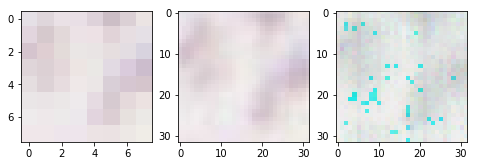

In [8]:
_predict_ith(1200, 8, 32)

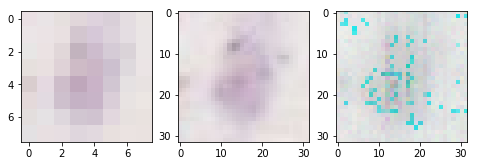

In [9]:
_predict_ith(1200, 8, 32)

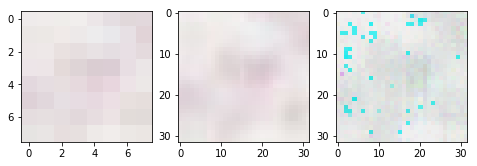

In [10]:
_predict_ith(1200, 8, 32)

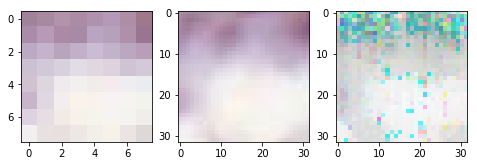

In [11]:
_predict_ith(1200, 8, 32)

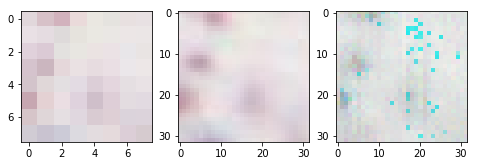

In [12]:
_predict_ith(1200, 8, 32)

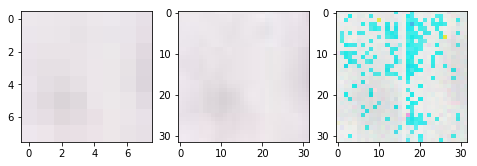

In [13]:

_predict_ith(1200, 8, 32)


In [14]:
bsize = 12

problem_name = "img2img_allen_brain_dim8to32"

args = _configure_experiment("lr-b%s-8to32" % bsize,
                             problem=problem_name,
                             num_gpu_per_worker=4,
                             batch_size=bsize,
                             num_steps=30000)

job = experiment.T2TExperiment(**args)

job.run()

[2018-07-16 21:16:44,816] /mnt/nfs-east1-d/work/tk
[2018-07-16 21:18:19,931] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-17 03:17:13,103] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-07-17 03:17:20,061] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-17 03:17:31,567] Finished loading event data for comparison.


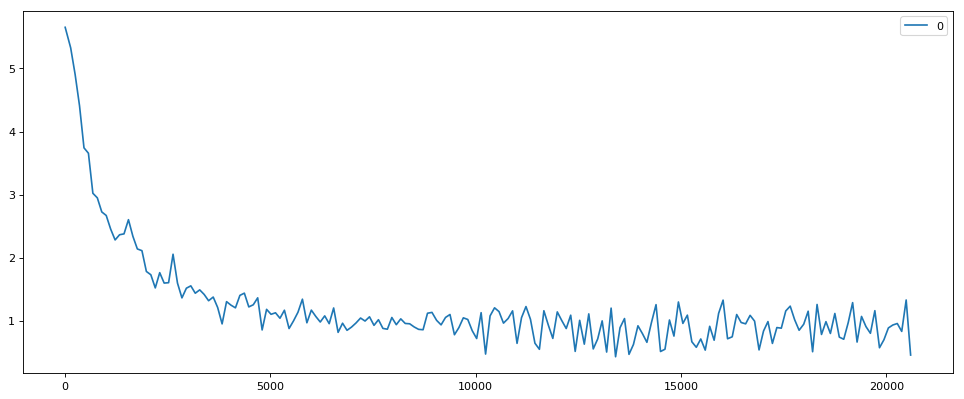

In [8]:
show_experiment_loss("lr-b12-8to32")


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-07-17 16:55:15,468] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


[2018-07-17 16:55:15,472] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-17 16:55:15,559] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-17 16:55:16,742] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-17 16:55:16,745] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-17 16:55:16,749] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-07-17 16:55:18,097] Transforming body output with identity_modality.top


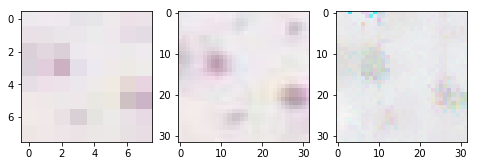

In [4]:

# About 20k iterations
ckpt_dir = "/mnt/nfs-east1-d/comparisons/lr-b12-8to32/lr-b12-8to32-j0716-2116-9978/output/master-0"
ckpt_path = _latest_ckpt_path(ckpt_dir)
model, dataset, problem_obj = _load_pdm(ckpt_dir)
_predict_ith(1200, 8, 32)


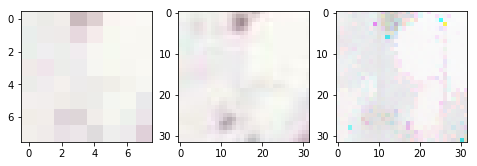

In [9]:
_predict_ith(1200, 8, 32)


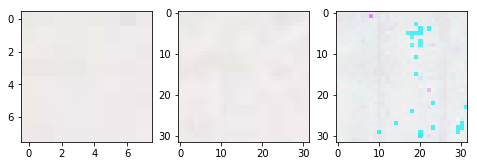

In [12]:
_predict_ith(1200, 8, 32)


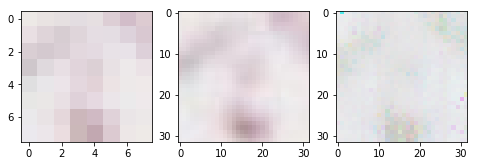

In [13]:
_predict_ith(1200, 8, 32)


### Adversarial Img2ImgTransformer

In [16]:
# Adding an adverarial loss to Transformer2D 

bsize = 4

problem_name = "img2img_allen_brain_dim8to32"
model = "img2img_transformer_adversarial"
hparams_set = "img2img_transformer_2d_adversarial"

args = _configure_experiment("adv-1",
                             problem=problem_name,
                             model=model,
                             hparams_set=hparams_set,
                             num_gpu_per_worker=4,
                             batch_size=bsize,
                             num_steps=10000)

job = experiment.T2TExperiment(**args)

job.run()

[2018-07-16 18:46:38,184] /mnt/nfs-east1-d/work/tk
[2018-07-16 18:48:10,041] smoke: True


In [ ]:

# CUDA_ERROR_OUT_OF_MEMORY and crash with NaN loss, same as above, which I'm guessing can be remedied by changing
# per_process_gpu_memory_fraction or similar. Not sure what changed to precipitate this issue. Could be related to
# a change in batch or model size. Indeed the model increased when adding the discriminator layers but the problem
# also already existed.

# The above ran successfully when the recent distribution-related TF_CONFIG parsing stuff was disabled


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-16 20:30:52,246] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-07-16 20:31:01,704] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-16 20:31:05,735] Finished loading event data for comparison.


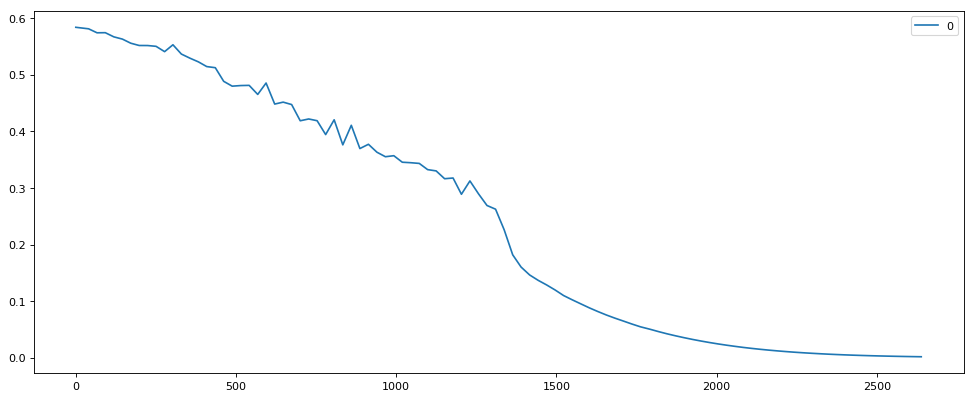

In [21]:

show_experiment_loss("adv-1")


In [ ]:

# So at least this trains, runs for the specified number of steps, and the loss goes down. We'll see how well it performed.
# I'm suspicious whether perhaps some of the target information may have leaked in given how smooth and perfect this
# loss curve looks. It might also be worth running replicas to see how reproducible this pattern is...


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


[2018-07-16 20:35:33,423] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-16 20:35:33,502] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-16 20:35:35,135] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-16 20:35:35,140] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-16 20:35:35,144] Building model body


INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


[2018-07-16 20:35:36,868] Skipping T2TModel top and loss because training loss returned from body


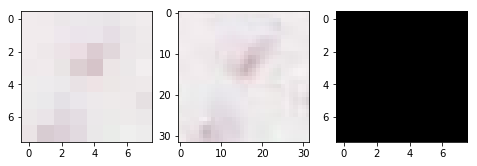

In [5]:

ckpt_dir = "/mnt/nfs-east1-d/comparisons/adv-1/adv-1-j0716-1846-9b92/output/master-0"
ckpt_path = _latest_ckpt_path(ckpt_dir)
model, dataset, problem_obj = _load_pdm(ckpt_dir)
_predict_ith(2100, 8, 32)


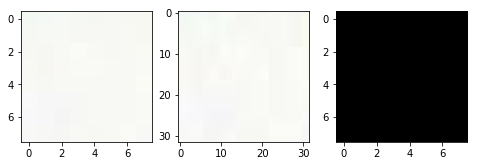

In [6]:
_predict_ith(1500, 8, 32)

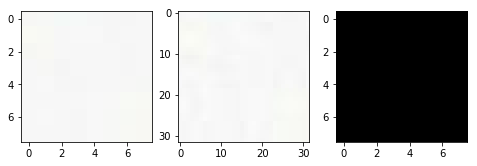

In [7]:
_predict_ith(1200, 8, 32)

In [ ]:

# Ok so looks like the loss is incentivizing producing black images which just means we need to re-tool our loss.

# OR! it could be running in train mode where it's configured to output zeros. can set it to run in eval mode... still need to
# figure out the best way to run inference... pixel-wise argmax might not be ideal...

# Oh and the streaky lines might be because it's using 1d attention instead of 2d? No looks like it's using 2D attention.


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-07-17 16:57:17,975] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


[2018-07-17 16:57:17,980] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-17 16:57:18,054] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-17 16:57:19,540] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-17 16:57:19,544] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-17 16:57:19,547] Building model body


INFO:tensorflow:Skipping T2TModel top and loss because training loss returned from body


[2018-07-17 16:57:20,992] Skipping T2TModel top and loss because training loss returned from body


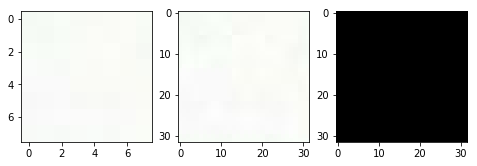

In [4]:

# Running in eval mode produces non-black images?

ckpt_dir = "/mnt/nfs-east1-d/comparisons/adv-1/adv-1-j0716-1846-9b92/output/master-0"
ckpt_path = _latest_ckpt_path(ckpt_dir)
model, dataset, problem_obj = _load_pdm(ckpt_dir)
_predict_ith(2100, 8, 32)


#### Larger batch

In [5]:

# Adding an adverarial loss to Transformer2D 

bsize = 12

problem_name = "img2img_allen_brain_dim8to32"
model = "img2img_transformer_adversarial"
hparams_set = "img2img_transformer_2d_adversarial"

args = _configure_experiment("adv-2",
                             problem=problem_name,
                             model=model,
                             hparams_set=hparams_set,
                             num_gpu_per_worker=4,
                             batch_size=bsize,
                             num_steps=10000)

job = experiment.T2TExperiment(**args)

job.run()


[2018-07-17 17:03:30,410] /mnt/nfs-east1-d/work/tk
[2018-07-17 17:04:44,656] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-17 21:11:01,815] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-07-17 21:11:09,308] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-17 21:11:14,974] Finished loading event data for comparison.


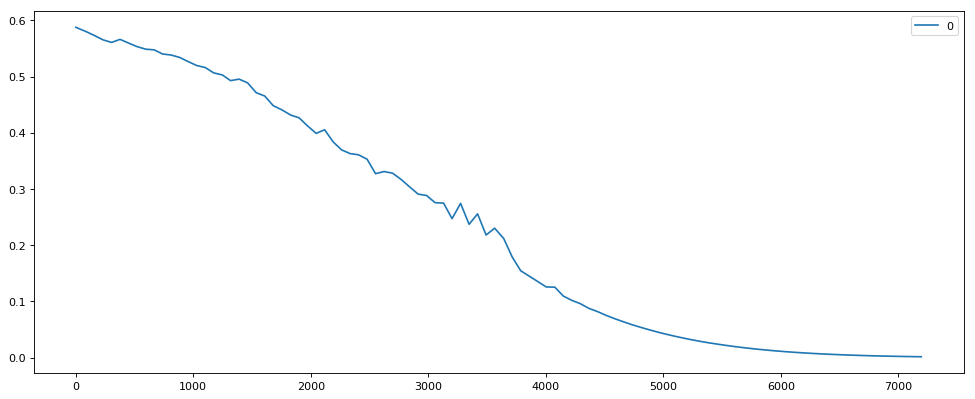

In [26]:

show_experiment_loss("adv-2")


In [ ]:

# Much smoother probably due to increased batch size.

# Let's take a look at predictions using various checkpoints along this range


In [ ]:

# Should be able to comment out the discriminator portion and 


#### With stock self.loss in addition to adversarial loss

In [28]:

bsize = 12

problem_name = "img2img_allen_brain_dim8to32"
model = "img2img_transformer_adversarial"
hparams_set = "img2img_transformer_2d_adversarial"

args = _configure_experiment("adv-withl2-2",
                             problem=problem_name,
                             model=model,
                             hparams_set=hparams_set,
                             num_gpu_per_worker=4,
                             batch_size=bsize,
                             num_steps=10000)

job = experiment.T2TExperiment(**args)

job.run()


[2018-07-17 21:13:40,905] /mnt/nfs-east1-d/work/tk
[2018-07-17 21:15:00,932] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-17 21:11:22,294] Identifying event files in experiment subdirectories...


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-17 21:11:29,734] Finished loading event data for comparison.
[2018-07-17 21:11:29,752] No handles with labels found to put in legend.


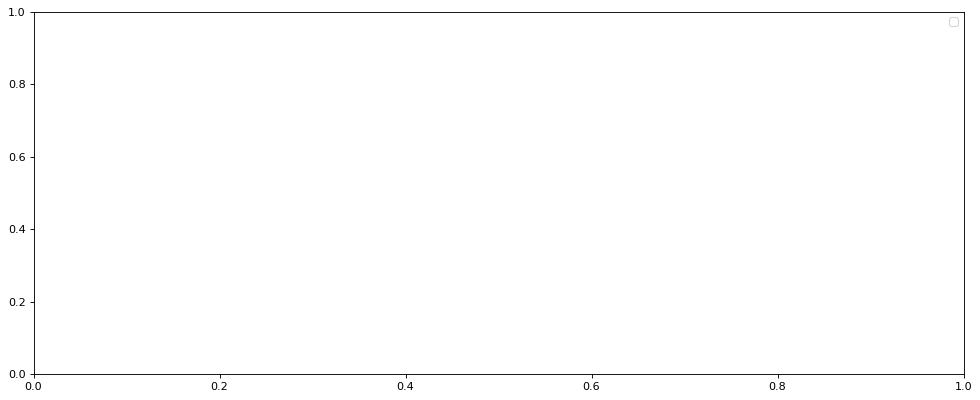

In [27]:

# Previous runs crashed or something, repeating
show_experiment_loss("adv-2-withl2")


#### Displays summaries? Much slower?

In [8]:
bsize = 4

problem_name = "img2img_allen_brain_dim8to32"
model = "img2img_transformer_adversarial"
hparams_set = "img2img_transformer_2d_adversarial"

args = _configure_experiment("adv-2-withl2-summaries",
                             problem=problem_name,
                             model=model,
                             hparams_set=hparams_set,
                             num_gpu_per_worker=1,
                             batch_size=bsize,
                             num_steps=1000)

job = experiment.T2TExperiment(**args)

job.run()


[2018-07-17 17:13:40,428] /mnt/nfs-east1-d/work/tk
[2018-07-17 17:14:57,104] smoke: True


In [ ]:
# Appears to have crashed for similar reason to the above

#### Updated adversarial loss, with summaries

In [30]:

bsize = 12

problem_name = "img2img_allen_brain_dim8to32"
model = "img2img_transformer_adversarial"
hparams_set = "img2img_transformer_2d_adversarial"

args = _configure_experiment("adv-3",
                             problem=problem_name,
                             model=model,
                             hparams_set=hparams_set,
                             num_gpu_per_worker=4,
                             batch_size=bsize,
                             num_steps=10000)

job = experiment.T2TExperiment(**args)

job.run()


[2018-07-17 22:49:06,545] /mnt/nfs-east1-d/work/tk
[2018-07-17 22:50:23,527] smoke: True


#### Third loss variant

In [31]:

bsize = 12

problem_name = "img2img_allen_brain_dim8to32"
model = "img2img_transformer_adversarial"
hparams_set = "img2img_transformer_2d_adversarial"

args = _configure_experiment("adv-l3-0",
                             problem=problem_name,
                             model=model,
                             hparams_set=hparams_set,
                             num_gpu_per_worker=4,
                             batch_size=bsize,
                             num_steps=10000)

job = experiment.T2TExperiment(**args)

job.run()



[2018-07-18 17:51:38,259] /mnt/nfs-east1-d/work/tk
[2018-07-18 17:52:59,763] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-18 18:49:05,006] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-07-18 18:49:13,814] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-18 18:49:16,336] Finished loading event data for comparison.


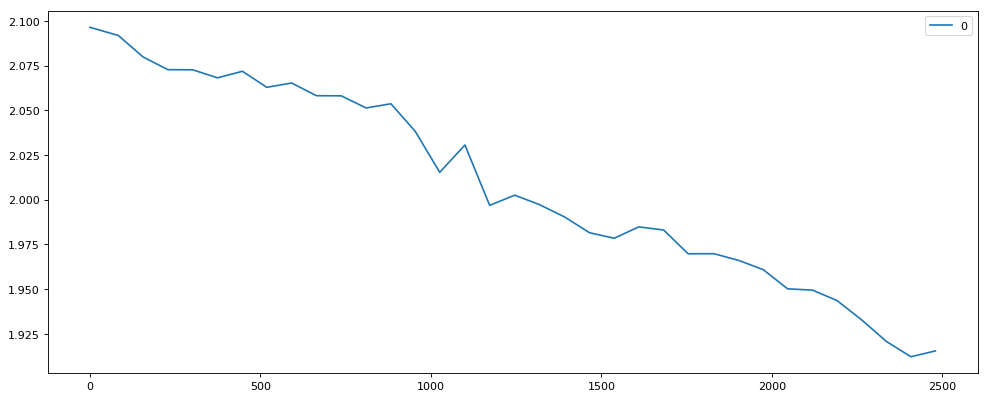

In [16]:
show_experiment_loss("adv-l3-0")

In [10]:

def infer(predictions):
    p = predictions.numpy()
    x_max = p.shape[1] # X-position in image
    y_max = p.shape[2] # Y-position in image
    c_max = p.shape[3] # Color channel (r,g,b)

    # The image we will populate
    image = np.zeros((1, x_max, y_max, c_max), dtype=np.uint8)

    batch_idx = 0

    for x in range(0, x_max):
        for y in range(0, y_max):
            for c in range(0, c_max):
                # Get the index of the greatest value in p[0][x][y][c]
                val = np.argmax(p[0][x][y][c])
                image[batch_idx][x][y][c] = np.uint8(np.argmax(p[0][x][y][c]))
    return image[0]

def _predict_ith_postargmax(offset, input_dim=8, output_dim=32):

    with tfe.restore_variables_on_create(ckpt_path):
      for count, example in enumerate(tfe.Iterator(dataset)):
          if count > offset:
            break
      fig=plt.figure(figsize=(8, 8))
      example["inputs"] = tf.reshape(example["inputs"], [1, input_dim, input_dim, 3])
      fig.add_subplot(1, 3, 1)
      plt.imshow(example["inputs"].numpy()[0])
      fig.add_subplot(1, 3, 2)
      example["targets"] = tf.reshape(example["targets"], [1, output_dim, output_dim, 3])
      plt.imshow(example["targets"].numpy()[0])
      example["targets"] = tf.reshape(tf.zeros((1, output_dim, output_dim, 3), dtype=np.uint8), [1, output_dim, output_dim, 3])
      predictions, _ = model(example)
      fig.add_subplot(1,3,3)
      plt.imshow(infer(predictions))
      plt.show()


In [6]:
ckpt_dir = "/mnt/nfs-east1-d/comparisons/adv-l3-0/adv-l3-0-j0718-1751-13c3/output/master-0"
ckpt_path = _latest_ckpt_path(ckpt_dir)
model, dataset, problem_obj = _load_pdm(ckpt_dir)

INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-07-18 18:54:27,278] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


[2018-07-18 18:54:27,283] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-18 18:54:27,379] partition: 0 num_data_files: 100


In [ ]:
# Let's look at a prediction from this model

offset=1200

with tfe.restore_variables_on_create(ckpt_path):
  for count, example in enumerate(tfe.Iterator(dataset)):
      if count > offset:
        break

predictions, _ = model(example)


#### Including scaled L2

In [32]:

bsize = 12

problem_name = "img2img_allen_brain_dim8to32"
model = "img2img_transformer_adversarial"
hparams_set = "img2img_transformer_2d_adversarial"

args = _configure_experiment("adv-l3-1",
                             problem=problem_name,
                             model=model,
                             hparams_set=hparams_set,
                             num_gpu_per_worker=4,
                             batch_size=bsize,
                             num_steps=10000)

job = experiment.T2TExperiment(**args)

job.run()



[2018-07-18 18:27:00,952] /mnt/nfs-east1-d/work/tk
[2018-07-18 18:28:22,369] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-18 18:49:16,635] Identifying event files in experiment subdirectories...


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-18 18:49:24,251] Finished loading event data for comparison.
[2018-07-18 18:49:24,269] No handles with labels found to put in legend.


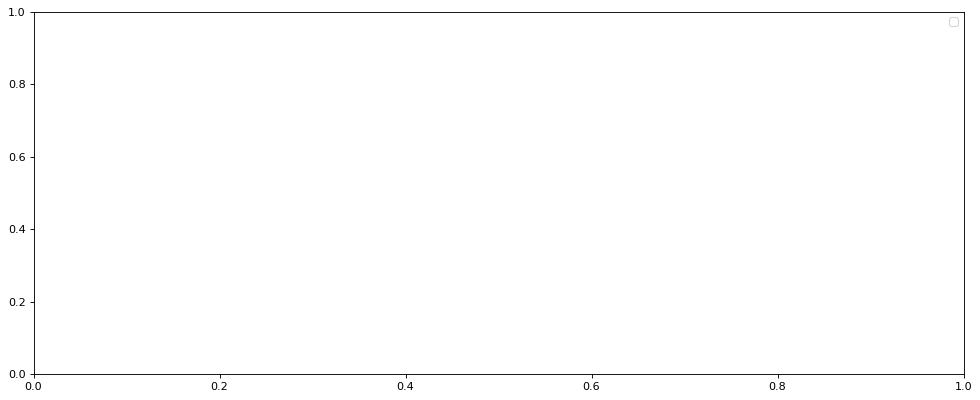

In [17]:
show_experiment_loss("adv-l3-1")

In [ ]:
# Crashed building model

#### Returns logits, no L2

In [18]:

bsize = 12

problem_name = "img2img_allen_brain_dim8to32"
model = "img2img_transformer_adversarial"
hparams_set = "img2img_transformer_2d_adversarial"

args = _configure_experiment("adv-l3-3",
                             problem=problem_name,
                             model=model,
                             hparams_set=hparams_set,
                             num_gpu_per_worker=4,
                             batch_size=bsize,
                             num_steps=30000)

job = experiment.T2TExperiment(**args)

job.run()


[2018-07-18 18:52:08,745] /mnt/nfs-east1-d/work/tk
[2018-07-18 18:53:28,720] smoke: True


In [ ]:
# Will probably crash because of l2 thing

In [ ]:
show_experiment_loss("adv-l3-2")

### Long in-painting run

In [7]:
bsize = 8

problem_name = "img2img_allen_brain_dim16to16_paint1"

args = _configure_experiment("lr-dim16to16-paint1",
                             problem=problem_name,
                             num_gpu_per_worker=4,
                             batch_size=bsize,
                             num_steps=30000)

job = experiment.T2TExperiment(**args)

job.run()

[2018-07-16 20:38:54,282] /mnt/nfs-east1-d/work/tk
[2018-07-16 20:40:33,178] smoke: True


INFO:tensorflow:Identifying event files in experiment subdirectories...


[2018-07-17 03:23:12,174] Identifying event files in experiment subdirectories...


INFO:tensorflow:Processing experiment events (1 of 1)


[2018-07-17 03:23:18,267] Processing experiment events (1 of 1)


INFO:tensorflow:Finished loading event data for comparison.


[2018-07-17 03:23:48,411] Finished loading event data for comparison.


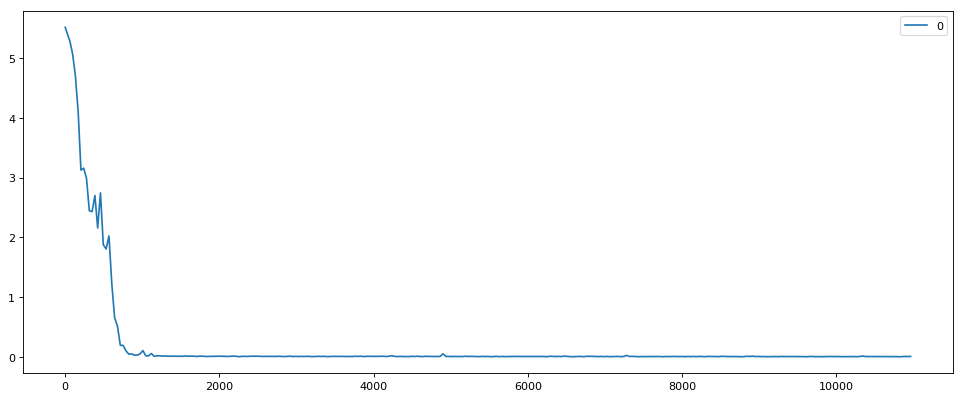

In [17]:

show_experiment_loss("lr-dim16to16-paint1")


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


[2018-07-16 21:06:16,641] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-16 21:06:16,732] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-16 21:06:17,936] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-16 21:06:17,941] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-16 21:06:17,945] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-07-16 21:06:18,829] Transforming body output with identity_modality.top


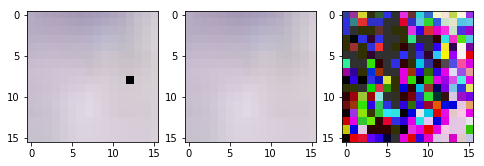

In [9]:

ckpt_dir = "/mnt/nfs-east1-d/comparisons/lr-dim16to16-paint1/lr-dim16to16-paint1-j0716-2038-abac/output/master-0"
ckpt_path = _latest_ckpt_path(ckpt_dir)
model, dataset, problem_obj = _load_pdm(ckpt_dir)
_predict_ith(1200, 16, 16)


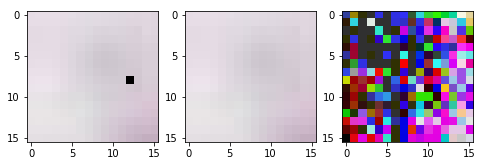

In [10]:
_predict_ith(1200, 16, 16)

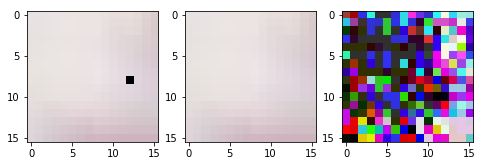

In [11]:
_predict_ith(1200, 16, 16)

In [ ]:

# Ugh all these black patches are in the same spot. Might be a random seed problem, could reconfigure to set seed
# based on a machine property.


INFO:tensorflow:Setting T2TModel mode to 'train'


[2018-07-17 03:20:39,756] Setting T2TModel mode to 'train'


INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


[2018-07-17 03:20:39,761] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-17 03:20:39,836] partition: 0 num_data_files: 100


INFO:tensorflow:Transforming feature 'inputs' with identity_modality.bottom


[2018-07-17 03:20:41,265] Transforming feature 'inputs' with identity_modality.bottom


INFO:tensorflow:Transforming 'targets' with identity_modality.targets_bottom


[2018-07-17 03:20:41,269] Transforming 'targets' with identity_modality.targets_bottom


INFO:tensorflow:Building model body


[2018-07-17 03:20:41,273] Building model body


INFO:tensorflow:Transforming body output with identity_modality.top


[2018-07-17 03:20:42,137] Transforming body output with identity_modality.top


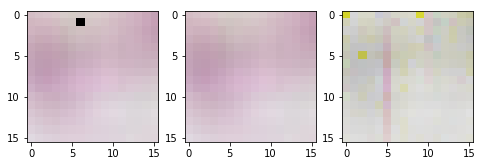

In [6]:
# 30k iterations

ckpt_dir = "/mnt/nfs-east1-d/comparisons/lr-dim16to16-paint1/lr-dim16to16-paint1-j0716-2038-abac/output/master-0"
ckpt_path = _latest_ckpt_path(ckpt_dir)
model, dataset, problem_obj = _load_pdm(ckpt_dir)
_predict_ith(1200, 16, 16)


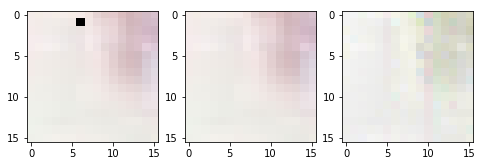

In [7]:
_predict_ith(1200, 16, 16)


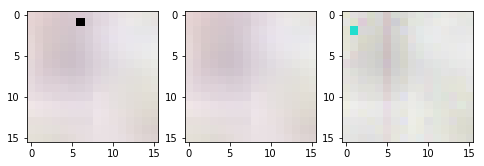

In [8]:
_predict_ith(1200, 16, 16)


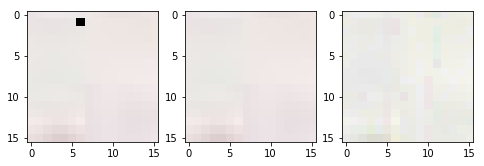

In [9]:
_predict_ith(1200, 16, 16)


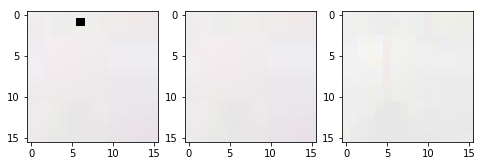

In [10]:
_predict_ith(1200, 16, 16)


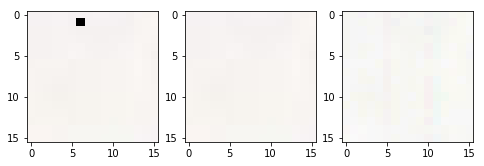

In [11]:
_predict_ith(1200, 16, 16)


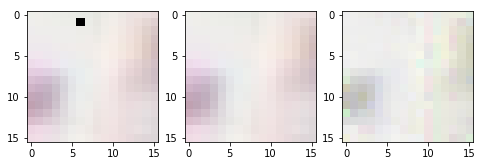

In [12]:
_predict_ith(1200, 16, 16)


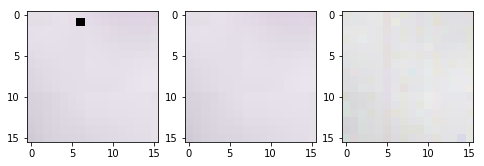

In [13]:
_predict_ith(1200, 16, 16)


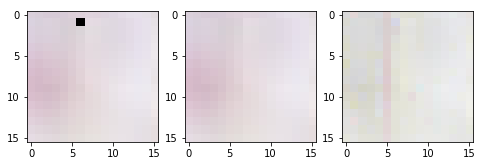

In [14]:
_predict_ith(1200, 16, 16)


In [ ]:

# Hmmm this is confusing - this seems like a pretty easy task. Guessing both the loss isn't right and the model
# and batch sizes are too small...

# Hmm so given the loss has pretty much bottomed out I'm going to guess this is in part the wrong type of loss.
# If the loss shows the images as identical then no further improvement in the optimization can be obtained.


#### Try examining examples directly

In [9]:
ckpt_dir = "/mnt/nfs-east1-d/comparisons/lr-dim16to16-paint1/lr-dim16to16-paint1-j0716-2038-abac/output/master-0"
model, dataset, problem_obj = _load_pdm(ckpt_dir)

INFO:tensorflow:Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


[2018-07-17 17:15:21,372] Reading data files from /mnt/nfs-east1-d/data/img2img_allen_brain-train*


INFO:tensorflow:partition: 0 num_data_files: 100


[2018-07-17 17:15:21,498] partition: 0 num_data_files: 100


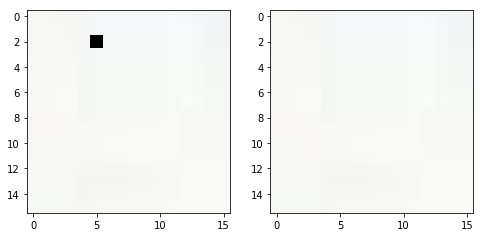

In [17]:

def show_one_example_pair(dataset, offset=1):
  for count, example in enumerate(tfe.Iterator(dataset)):
      if count > offset:
        break
  input_dim = example["inputs"].shape[1]
  fig=plt.figure(figsize=(8, 8))
  example["inputs"] = tf.reshape(example["inputs"], [1, input_dim, input_dim, 3])
  fig.add_subplot(1, 2, 1)
  plt.imshow(example["inputs"].numpy()[0])
  fig.add_subplot(1, 2, 2)
  output_dim = example["targets"].shape[1]
  example["targets"] = tf.reshape(example["targets"], [1, output_dim, output_dim, 3])
  plt.imshow(example["targets"].numpy()[0])
  plt.show()


show_one_example_pair(dataset)

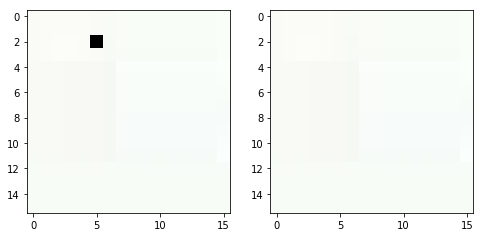

In [18]:
show_one_example_pair(dataset)

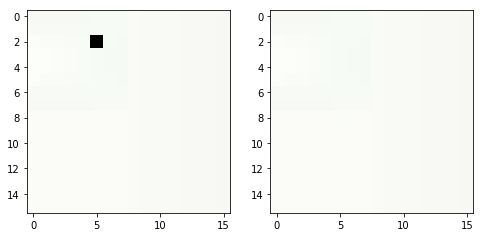

In [19]:
show_one_example_pair(dataset)

In [ ]:

# So yes all of these examples have a black patch in the same place. But this is in a different position from
# the couple other examples above.



### Distributed run debugging shared/separate checkpoint dirs


In [ ]:

# Saw something in t2t distributed docs saying different workers need to share the output_dir so
# will repeat run with that approach - but curious about potential collision of same-name flags.txt,
# flags_t2t.txt, etc. files that motivated the split in the first case.


### Next/future

In [25]:

# Multi-node distributed training to push batch size higher

# Playing around with custom models and losses

# Different approach that avoids this repeated shutil.copytree stuff....

# Given what I'm seeing above it would seem worthwhile to work with something like 24->32 with
# context.

# Pre-training
# I wonder what would happen if we pre-trained on a small version of the problem before going
# to the big one. As well as perhaps pre-training going 8->16 before 8->32.
# Interested in understanding what happens if we add layers to a previously-trained model, whether
# it can just be extended or needs to be re-trained (solely given change in hparam).

# Being able to run 8xgpu nodes - not sure what the issue is here

# Parllel inference?

# Curious about image standardization

# Batch norm?

# GPUs with more memory would help run larger batches
# K80: 12
# P/V100: 16

# Using a larger model than that specified by img2img_transformer2d_tiny would be cool to try
# Would value input from algorithm authors on whether this memory usage is reasonable but guessing
# it is and that you just need a lot of GPUs to train it well.

# So apparently you can run the decoder for a problem shape it wasn't trained on???

# Notebook widget for launching a run, showing logs, storing notes?
# Notebook widget for showing runs in progress? Current setup may be sufficient.

# Try using ranged hyperparameter objects as bounds for hparam suggestions that are used in jobs
